In [1]:
%reset -sf

import tensorflow as tf
print("Tensorflow:", tf.__version__)


# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        
        # Instead of enabling memory growth, set a memory limit
        memory_limit = 16_376 # Set the memory limit in MB
        # memory_limit = -1
        if memory_limit >= 0:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
            )
            
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2024-11-04 02:40:42.490118: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 02:40:42.509595: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow: 2.13.0
1 Physical GPUs, 1 Logical GPU


2024-11-04 02:40:43.843906: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16376 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [2]:
import sys
import os
import glob

HOME_PATH = os.path.abspath("..")
sys.path.insert(0, HOME_PATH + "/qe")

import atlas_plot as ap

plot = ap.Plotter()

import pandas as pd
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

SEED = 42  # set random seed (global variable)
GEV = 1e-3

In [3]:
from dataclasses import dataclass

data_path = "/root/data/recotruth/PowPy8_345324_legacy_data.h5"


def pt(px, py):
    return np.sqrt(np.square(px) + np.square(py))


def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))


def phi(px, py):
    return np.arctan2(py, px)


def m(p4):
    return np.sqrt(
        np.square(p4[:, 3])
        - np.square(p4[:, 0])
        - np.square(p4[:, 1])
        - np.square(p4[:, 2])
    )


@dataclass
class Lead_lep:
    px = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPx"] * GEV
    py = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPy"] * GEV
    pz = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPz"] * GEV
    energy = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepE"] * GEV
    pt = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPt"] * GEV
    eta = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepEta"]
    phi = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Sublead_lep:
    px = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPx"] * GEV
    py = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPy"] * GEV
    pz = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPz"] * GEV
    energy = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepE"] * GEV
    pt = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPt"] * GEV
    eta = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepEta"]
    phi = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Dilep:
    lead = Lead_lep()
    sublead = Sublead_lep()
    p4 = Lead_lep.p4 + Sublead_lep.p4
    p3 = p4[:, :3]
    px = p4[:, 0]
    py = p4[:, 1]
    pz = p4[:, 2]
    energy = p4[:, 3]
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    m = m(p4)


@dataclass
class Met:
    px = pd.read_hdf(data_path, "reco_met")["RecoMETPx"] * GEV
    py = pd.read_hdf(data_path, "reco_met")["RecoMETPy"] * GEV
    phi = pd.read_hdf(data_path, "reco_met")["RecoMETPhi"]
    pt = pt(px, py)


@dataclass
class Truth_lead_lep:
    px = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPx"] * GEV
    py = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPy"] * GEV
    pz = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPz"] * GEV
    energy = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepE"] * GEV
    pt = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPt"] * GEV
    eta = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepEta"]
    phi = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Truth_sublead_lep:
    px = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPx"] * GEV
    py = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPy"] * GEV
    pz = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPz"] * GEV
    energy = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepE"] * GEV
    pt = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPt"] * GEV
    eta = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepEta"]
    phi = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Truth_dilep:
    lead = Truth_lead_lep()
    sublead = Truth_sublead_lep()
    p4 = Lead_lep.p4 + Sublead_lep.p4
    p3 = p4[:, :3]
    px = p4[:, 0]
    py = p4[:, 1]
    pz = p4[:, 2]
    energy = p4[:, 3]
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    m = m(p4)


@dataclass
class Truth_met:
    px = pd.read_hdf(data_path, "truth_met")["TruthRecoMETPx"] * GEV
    py = pd.read_hdf(data_path, "truth_met")["TruthRecoMETPy"] * GEV
    phi = pd.read_hdf(data_path, "truth_met")["TruthRecoMETPhi"]
    pt = pt(px, py)


@dataclass
class Lead_w:
    px = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPx"] * GEV
    py = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPy"] * GEV
    pz = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPz"] * GEV
    energy = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWE"] * GEV
    pt = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPt"] * GEV
    eta = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWEta"]
    phi = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPhi"]
    m = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWM"] * GEV
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Sublead_w:
    px = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPx"] * GEV
    py = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPy"] * GEV
    pz = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPz"] * GEV
    energy = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWE"] * GEV
    pt = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPt"] * GEV
    eta = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWEta"]
    phi = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPhi"]
    m = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWM"] * GEV
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T

In [4]:
# reco
lead_lep = Lead_lep()
sublead_lep = Sublead_lep()
dilep = Dilep()
met = Met()

# truth
truth_lead_lep = Truth_lead_lep()
truth_sublead_lep = Truth_sublead_lep()
Truth_dilep = Truth_dilep()
truth_met = Truth_met()

# target Ws
w_lead = Lead_w()
w_sublead = Sublead_w()

In [5]:
# define preselection cuts

# cut_pre_pt_lead = lead_lep.pt > 22
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
# cut_pre_pt_sub = sublead_lep.pt > 15
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
# cut_pre_dilep_m = (
#     np.sqrt(
#         np.square(lead_lep.energy + sublead_lep.energy)
#         - np.square(lead_lep.px + sublead_lep.px)
#         - np.square(lead_lep.py + sublead_lep.py)
#         - np.square(lead_lep.pz + sublead_lep.pz)
#     )
#     > 10
# )
# print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
# cut_pre_pt_miss = met.pt > 20
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
# PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
# print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
# del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

# define preselection cuts

cut_pre_pt_lead = lead_lep.pt > -999999
print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = sublead_lep.pt > -999999
print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > -999999
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = met.pt > -999999
print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

0
0
0
0
0


In [6]:
## Observing variables

obs_kin = np.column_stack(
    (
        lead_lep.px,
        lead_lep.py,
        # lead_lep.pz,
        # lead_lep.energy,
        np.log(lead_lep.energy),
        # np.log(lead_lep.pt),
        lead_lep.eta,
        # lead_lep.phi,
        sublead_lep.px,
        sublead_lep.py,
        # sublead_lep.pz,
        # sublead_lep.energy,
        np.log(sublead_lep.energy),
        # np.log(sublead_lep.pt),
        sublead_lep.eta,
        # sublead_lep.phi,
        met.px,
        met.py,
        # met.pt,
        # met.phi,
        # dilep.px,
        # dilep.py,
        # dilep.pz,
        # np.log(dilep.energy),
        # dilep.pt,
        # dilep.eta,
        # dilep.phi,
        # dilep.m,
    )
)[PRE_CUT]

# Kinematics of observing variables (inputs for training)
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array

ROBUST_OBS = StandardScaler()
obs_kin = ROBUST_OBS.fit_transform(obs_kin)
print(type(obs_kin))

int_kin shape: (1277395, 10)
<class 'numpy.ndarray'>


In [7]:
## Interesting variables

w_lead_px = pd.DataFrame(w_lead.px[PRE_CUT])
w_lead_py = pd.DataFrame(w_lead.py[PRE_CUT])
w_lead_pz = pd.DataFrame(w_lead.pz[PRE_CUT])
w_lead_e = pd.DataFrame(w_lead.energy[PRE_CUT])
w_lead_log_e = pd.DataFrame(np.log(w_lead_e))
w_lead_sqrt_e = pd.DataFrame(np.sqrt(w_lead_e))
w_sublead_px = pd.DataFrame(w_sublead.px[PRE_CUT])
w_sublead_py = pd.DataFrame(w_sublead.py[PRE_CUT])
w_sublead_pz = pd.DataFrame(w_sublead.pz[PRE_CUT])
w_sublead_e = pd.DataFrame(w_sublead.energy[PRE_CUT])
w_sublead_log_e = pd.DataFrame(np.log(w_sublead_e))
w_sublead_sqrt_e = pd.DataFrame(np.sqrt(w_sublead_e))
w_lead_m = pd.DataFrame(w_lead.m[PRE_CUT])
w_sublead_m = pd.DataFrame(w_sublead.m[PRE_CUT])

# Kinematics of interesting variables (target for training)
int_kin = np.concatenate(
    [
        w_lead_px,
        w_lead_py,
        w_lead_pz,
        w_lead_e,
        w_sublead_px,
        w_sublead_py,
        w_sublead_pz,
        w_sublead_e,
        # np.square(w_lead_m) / np.mean(w_lead_m),
        # np.square(w_sublead_m) / np.mean(w_lead_m),
        # w_lead_m,
        # w_sublead_m,
    ],
    axis=-1,
)
print("int_kin shape:", int_kin.shape)
# int_kin = int_kin.to_numpy()  # convert to numpy array
print(type(int_kin))

int_kin shape: (1277395, 8)
<class 'numpy.ndarray'>


In [8]:
# lead_w_m2 = plt.hist([np.square(np.array(w_lead_m).flatten()) / np.mean(w_lead_m), np.square(np.array(w_sublead_m).flatten()) / np.mean(w_lead_m)], bins=81, stacked=True)
# plt.show()
# lead_w_m2 = plt.hist([np.array(w_lead_m).flatten(), np.array(w_sublead_m).flatten()], bins=81, stacked=True)

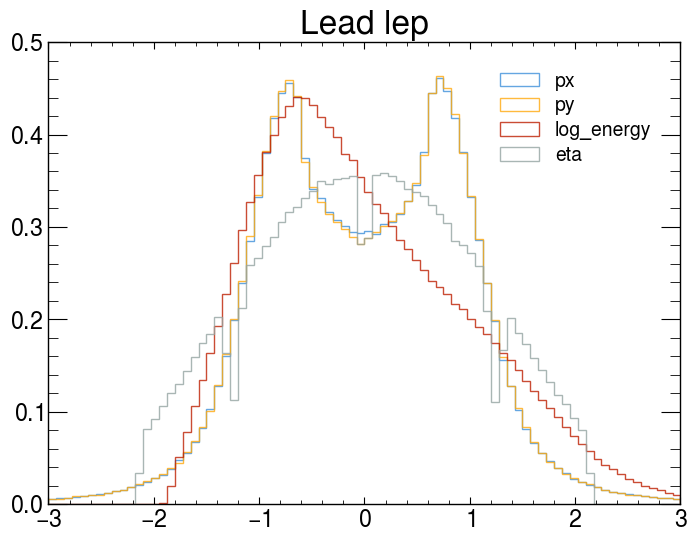

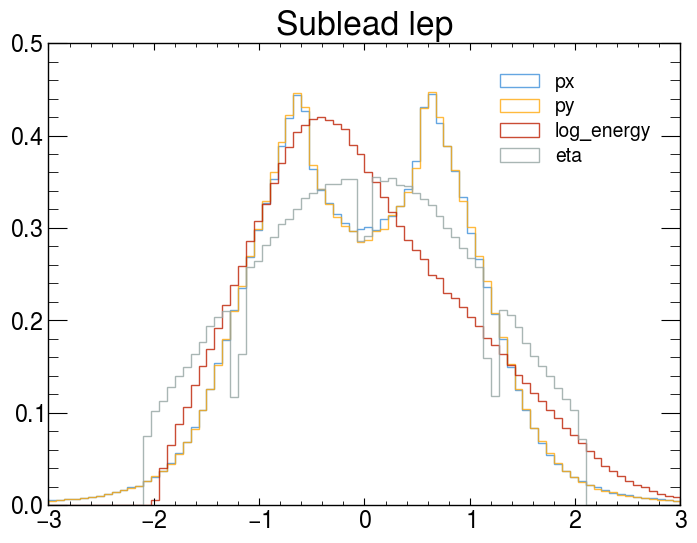

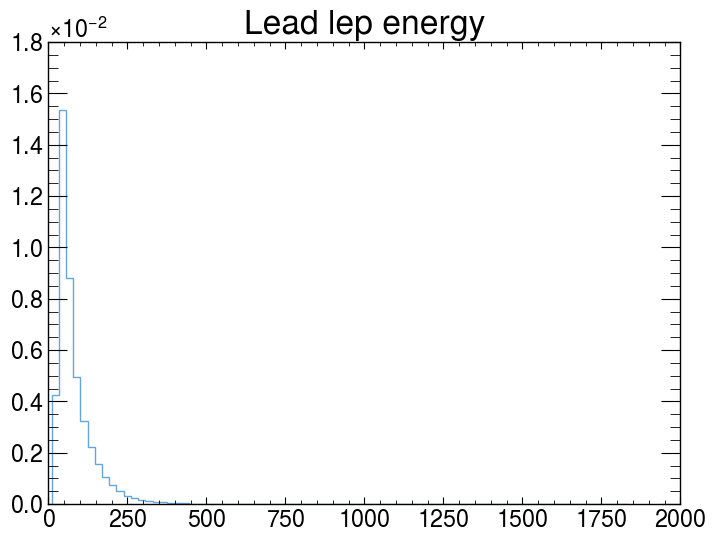

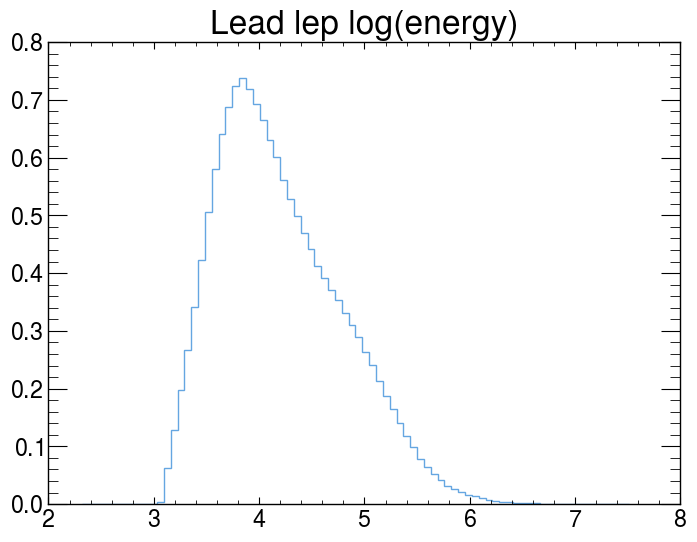

In [9]:
bin_edge = np.linspace(-3, 3, 81)
sublead_px = plt.hist(
    obs_kin[:, 0], bins=bin_edge, alpha=0.8, label="px", histtype="step", density=True
)
lead_py = plt.hist(
    obs_kin[:, 1], bins=bin_edge, alpha=0.8, label="py", histtype="step", density=True
)
lead_log_e = plt.hist(
    obs_kin[:, 2],
    bins=bin_edge,
    alpha=0.8,
    label="log_energy",
    histtype="step",
    density=True,
)
# lead_px = plt.hist(w_lead_px, bins=bin_edge, alpha=.8)
lead_pz = plt.hist(
    obs_kin[:, 3], bins=bin_edge, alpha=0.8, label="eta", histtype="step", density=True
)
# lead_px = plt.hist(w_lead_m, bins=bin_edge, alpha=.8)
# plt.yscale("log")
plt.title("Lead lep")
plt.legend()
plt.show()

sublead_px = plt.hist(
    obs_kin[:, 4], bins=bin_edge, alpha=0.8, label="px", histtype="step", density=True
)
sublead_py = plt.hist(
    obs_kin[:, 5], bins=bin_edge, alpha=0.8, label="py", histtype="step", density=True
)
sublead_log_e = plt.hist(
    obs_kin[:, 6],
    bins=bin_edge,
    alpha=0.8,
    label="log_energy",
    histtype="step",
    density=True,
)
sublead_pz = plt.hist(
    obs_kin[:, 7], bins=bin_edge, alpha=0.8, label="eta", histtype="step", density=True
)
# sublead_px = plt.hist(w_sublead_px, bins=bin_edge, alpha=.8)
# sublead_px = plt.hist(w_sublead_m, bins=bin_edge, alpha=.8)
# plt.yscale("log")
plt.title("Sublead lep")
plt.legend()
plt.show()


lead_energy = plt.hist(lead_lep.energy, bins=80, alpha=0.8, label="eta", histtype="step", density=True)
plt.title("Lead lep energy")
plt.show()
lead_log_energy = plt.hist(np.log(lead_lep.energy), bins=80, alpha=0.8, label="eta", histtype="step", density=True)
plt.title("Lead lep log(energy)")
plt.show()

In [10]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.8,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
# test_x = np.concatenate([test_x, valid_x], axis=0)
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]
# test_y = np.concatenate([test_y, valid_y], axis=0)

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

X (Interest)
Training data shape: (1021916, 10);
Validing data shape: (127739, 10);
Testing data shape: (127740, 10).
Y (Observed)
Training data shape: (1021916, 8);
Validing data shape: (127739, 8);
Testing data shape: (127740, 8).


In [11]:
# training variables
BATCH_SIZE = 1024
EPOCHS = 1024
LEARNING_RATE = 1e-4

In [ ]:
def dense_dropout_block(x, units, activation="elu", dropout_rate=0.2, l2=0.0):
    x = tf.keras.layers.Dense(
        units=units,
        activation=activation,
        kernel_regularizer=tf.keras.regularizers.L2(l2=l2),
    )(x)
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x


def residual_block(x, units, activation="elu", dropout_rate=0.0, l2=0.0):
    x = dense_dropout_block(x, units, dropout_rate=dropout_rate, activation=activation, l2=l2)
    y = dense_dropout_block(x, units // 2, dropout_rate=dropout_rate, activation=activation, l2=l2/2)
    y = dense_dropout_block(y, units, dropout_rate=dropout_rate, activation=activation, l2=l2)
    z = tf.keras.layers.Add()([x, y])
    z = tf.keras.layers.Activation(activation)(z)
    z = tf.keras.layers.BatchNormalization()(z)
    return z

def build_model():
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # construct the model
    for _ in range(3):
        x = residual_block(x, 256, dropout_rate=0.02, l2=0.0)
        x = residual_block(x, 512, dropout_rate=0.03, l2=0.0) # 0.04
        x = residual_block(x, 128, dropout_rate=0.01, l2=0.0)
        
    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="linear")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [13]:
model = build_model()
model.summary()
# tf.keras.utils.plot_model(model, to_file="WWResDNNRegressor.png", show_shapes=True, show_layer_names=False)

2024-11-04 02:40:48.013134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 15.99GiB (17171480576 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 flatten (Flatten)           (None, 10)                   0         ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 256)                  2816      ['flatten[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256)                  0         ['dense[0][0]']               
                                                                                              

In [14]:
# Define data generators with reduced batch size
def data_generator(x, y, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = (
        dataset.shuffle(buffer_size=len(x))
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return dataset


# Create training and validation generators
train_generator = data_generator(train_x, train_y, BATCH_SIZE)
valid_generator = data_generator(valid_x, valid_y, BATCH_SIZE)

# Compile the model
model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
)

# Early stopping and learning rate scheduler
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=8,
    mode="auto",
    restore_best_weights=False,
)


def scheduler(epoch, lr):
    if epoch < 512:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1 * LEARNING_RATE))


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Fit the model using generators
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[stop_early, lr_scheduler],
    verbose=2,
)

Epoch 1/1024


2024-11-04 02:40:55.223258: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-04 02:40:55.240917: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5716ff5c5b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-04 02:40:55.240933: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-11-04 02:40:55.244034: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-04 02:40:55.255522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-04 02:40:55.327978: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of

998/998 - 32s - loss: 62.4501 - val_loss: 59.0771 - lr: 1.0000e-04 - 32s/epoch - 32ms/step
Epoch 2/1024
998/998 - 20s - loss: 57.0161 - val_loss: 53.2441 - lr: 1.0000e-04 - 20s/epoch - 20ms/step
Epoch 3/1024
998/998 - 20s - loss: 51.0020 - val_loss: 47.2246 - lr: 1.0000e-04 - 20s/epoch - 20ms/step
Epoch 4/1024
998/998 - 22s - loss: 44.8984 - val_loss: 41.2522 - lr: 1.0000e-04 - 22s/epoch - 22ms/step
Epoch 5/1024
998/998 - 21s - loss: 39.1613 - val_loss: 36.0372 - lr: 1.0000e-04 - 21s/epoch - 21ms/step
Epoch 6/1024
998/998 - 20s - loss: 34.5434 - val_loss: 31.9263 - lr: 1.0000e-04 - 20s/epoch - 20ms/step
Epoch 7/1024
998/998 - 21s - loss: 31.3476 - val_loss: 29.1060 - lr: 1.0000e-04 - 21s/epoch - 21ms/step
Epoch 8/1024
998/998 - 21s - loss: 28.9159 - val_loss: 27.1654 - lr: 1.0000e-04 - 21s/epoch - 21ms/step
Epoch 9/1024
998/998 - 21s - loss: 27.3653 - val_loss: 26.0882 - lr: 1.0000e-04 - 21s/epoch - 21ms/step
Epoch 10/1024
998/998 - 20s - loss: 26.7777 - val_loss: 25.7283 - lr: 1.0000e

In [15]:
# Make a directory
dir_name = HOME_PATH + "/7th_trial/ww_resregressor_result/"
name = "ww_resregressor"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
        print(f"Directory {dir_name} cleaned.")
    print(f"Directory {dir_name} exists.")
else:
    os.makedirs(dir_name)
    print(f"Directory {dir_name} created.")

# save modela
model.save(dir_name + name + ".keras", save_format="keras", overwrite=True)

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

Directory /root/work/QE-mls/7th_trial/ww_resregressor_result/ cleaned.
Directory /root/work/QE-mls/7th_trial/ww_resregressor_result/ exists.
3992/3992 [==============================] - 19s 5ms/step


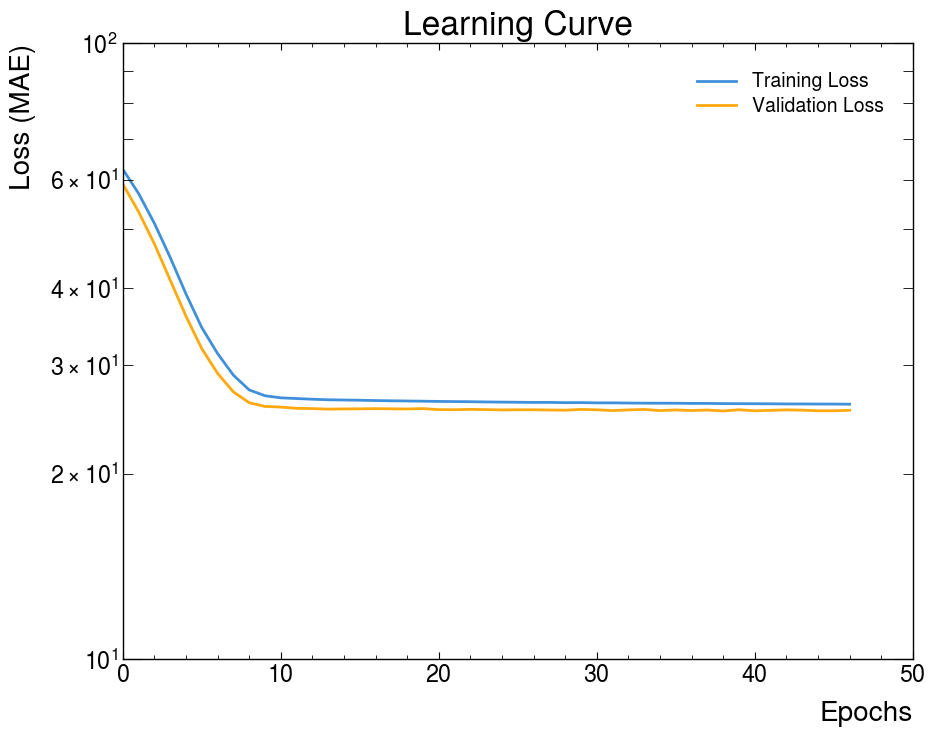

In [16]:
# Extract loss values
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Plot training and validation losses
plt.figure(figsize=(10, 8))
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss (MAE)")
plt.title("Learning Curve")
plt.legend()
plt.grid(False)
plt.show()

In [17]:
# save predicted results
np.savez_compressed(
    dir_name + name + "_data.npz",
    pred_y=sig_pred.reshape(sig_truth.shape),
    test_y=sig_truth,
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

Truth mean: 0.118, std: 38.116, min: -509.129, max: 642.655


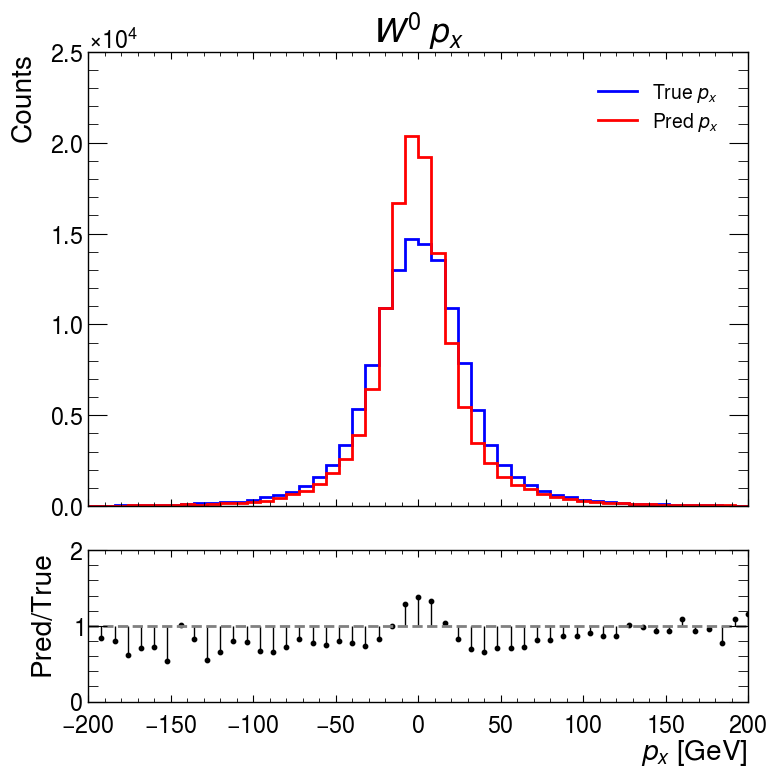

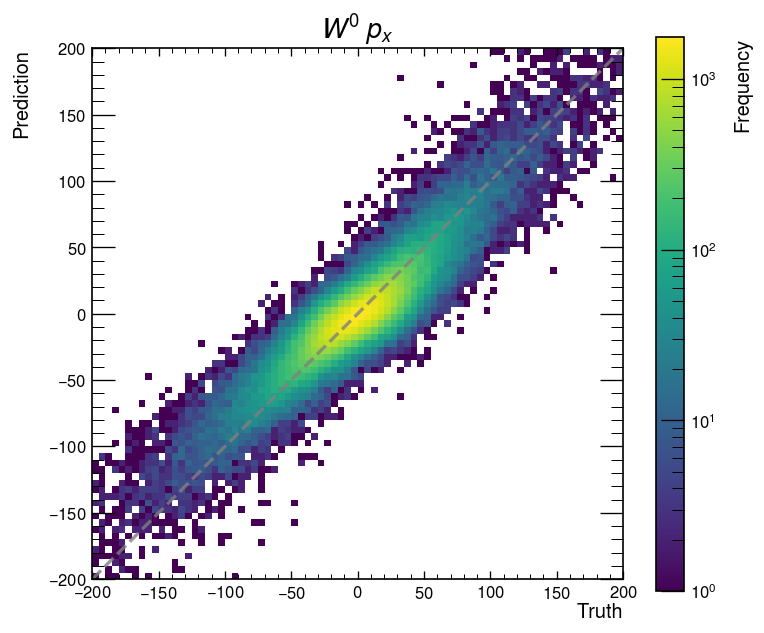

In [18]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 0], sig_pred_inv[:, 0]],
    label=r"$p_{x}$",
    title="$W^{0}$ $p_{x}$",
    # # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 0],
    sig_pred_inv[:, 0],
    r"$W^{0}$ $p_{x}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0])):.3f}",
    range=set_range,
    # bins = 50
)

Truth mean: 0.058, std: 26.084, min: -450.792, max: 414.779


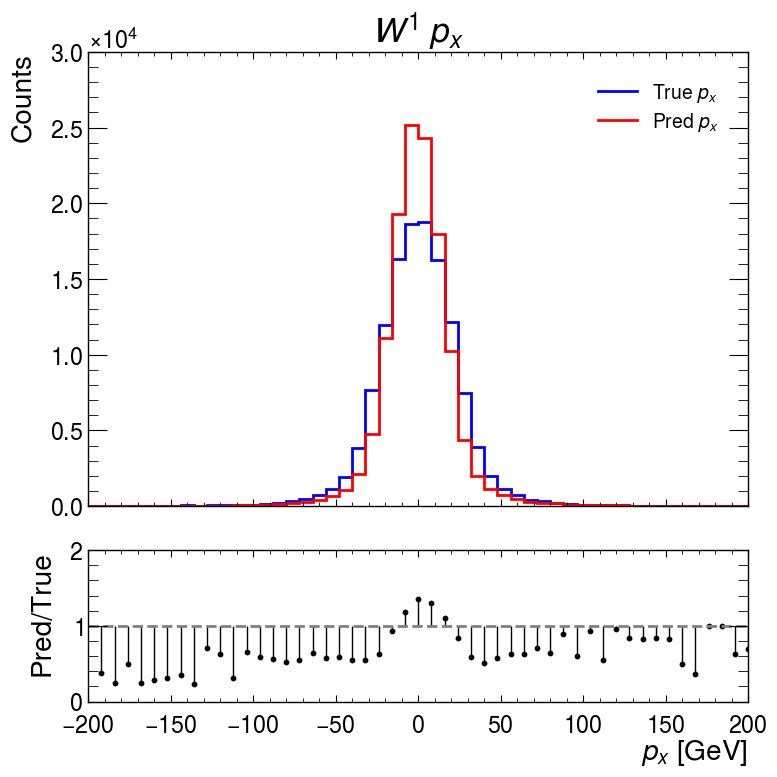

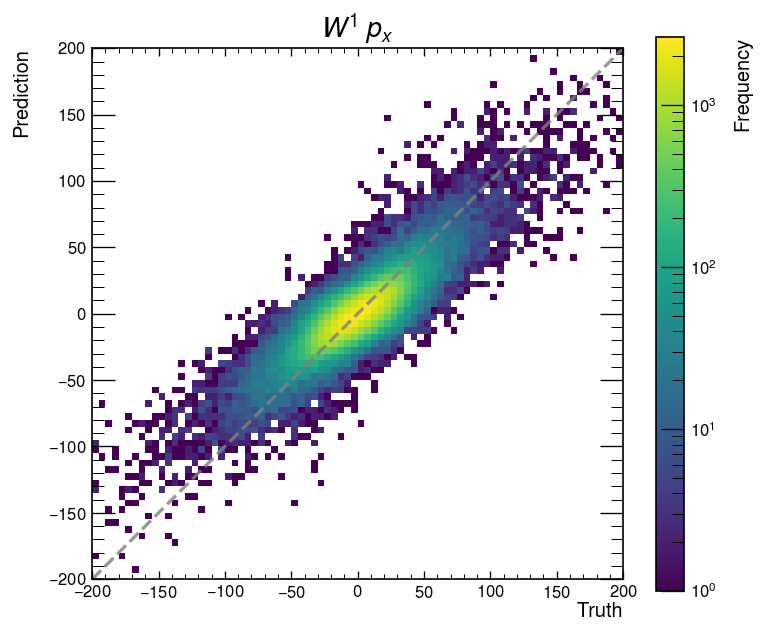

In [19]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,4]):.3f}, std: {np.std(sig_truth_inv[:,4]):.3f}, min: {np.min(sig_truth_inv[:,4]):.3f}, max: {np.max(sig_truth_inv[:,4]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 4], sig_pred_inv[:, 4]],
    label=r"$p_{x}$",
    title="$W^{1}$ $p_{x}$",
    # # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 4],
    sig_pred_inv[:, 4],
    r"$W^{1}$ $p_{x}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4])):.3f}",
    range=set_range,
)

Truth mean: 0.043, std: 38.211, min: -552.205, max: 490.982


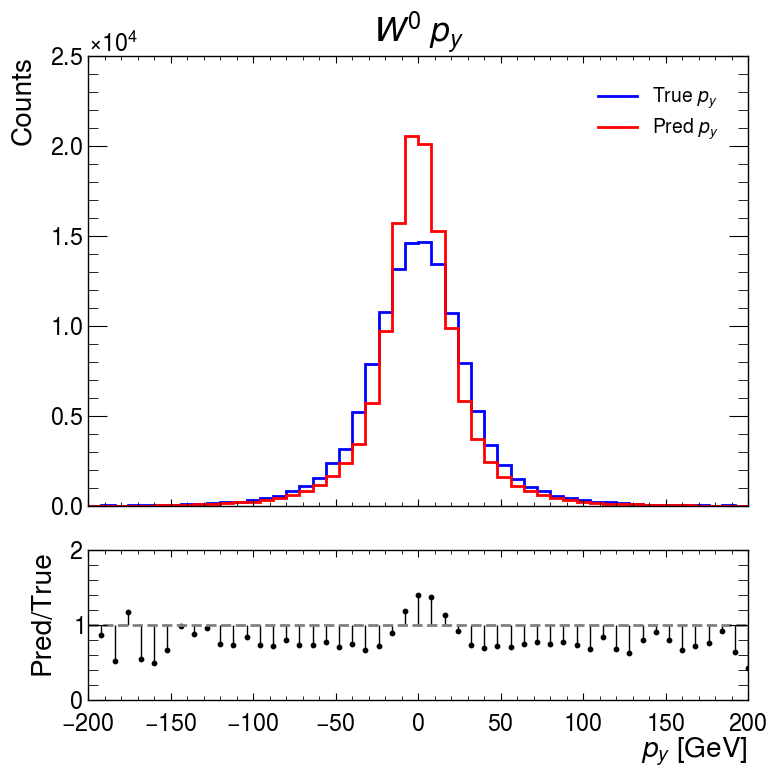

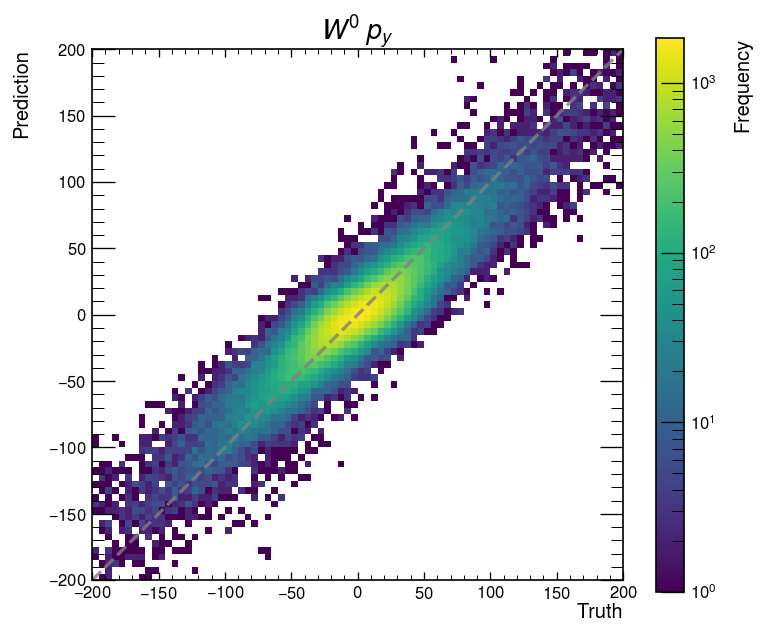

In [20]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 1], sig_pred_inv[:, 1]],
    label=r"$p_{y}$",
    title="$W^{0}$ $p_{y}$",
    # # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 1],
    sig_pred_inv[:, 1],
    r"$W^{0}$ $p_{y}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=set_range,
)

Truth mean: -0.006, std: 26.259, min: -420.723, max: 544.802


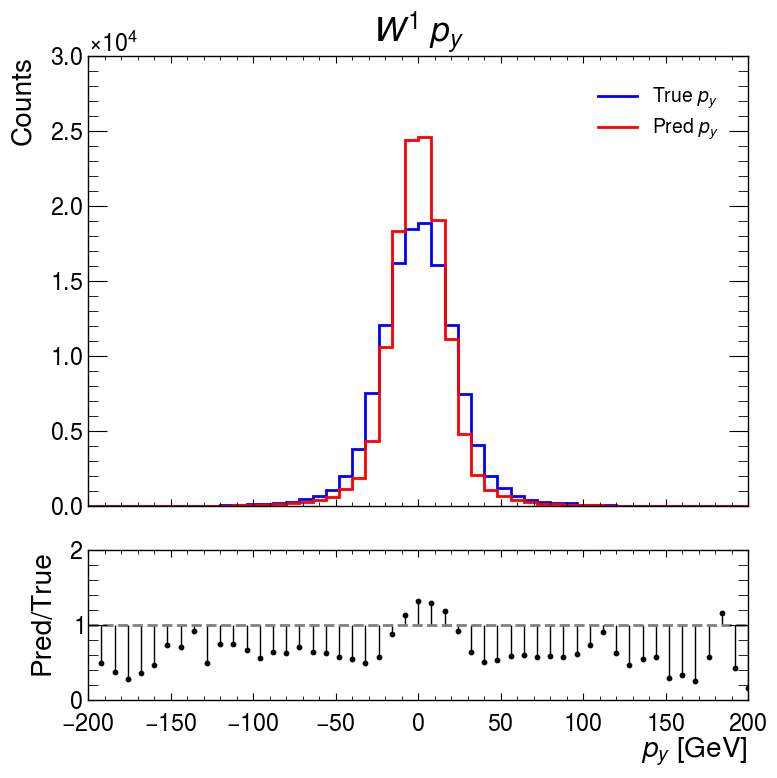

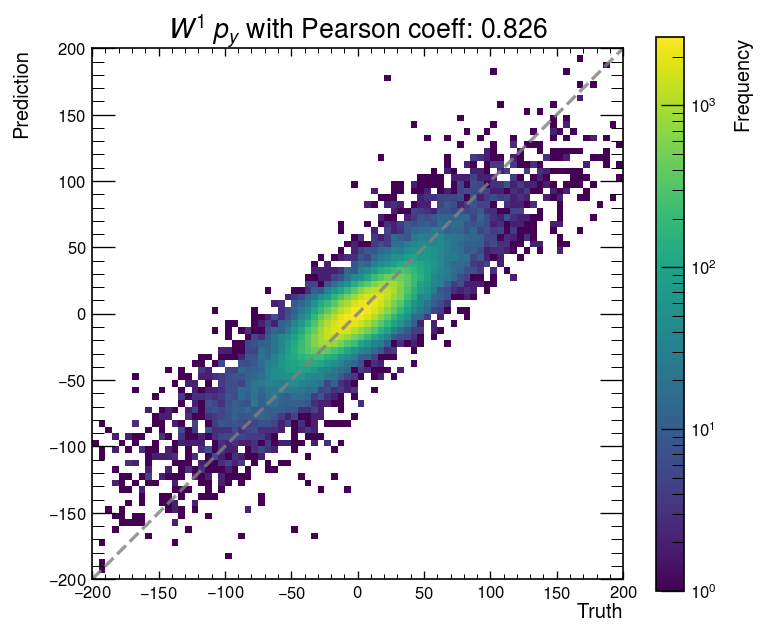

In [21]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,5]):.3f}, std: {np.std(sig_truth_inv[:,5]):.3f}, min: {np.min(sig_truth_inv[:,5]):.3f}, max: {np.max(sig_truth_inv[:,5]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 5], sig_pred_inv[:, 5]],
    label=r"$p_{y}$",
    title="$W^{1}$ $p_{y}$",
    # # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,5], sig_pred_inv[:,5])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 5],
    sig_pred_inv[:, 5],
    r"$W^{1}$ $p_{y}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,5], sig_pred_inv[:,5])[0]:.3f}",
    range=set_range,
)

Truth mean: 0.370, std: 174.439, min: -1558.070, max: 1793.634


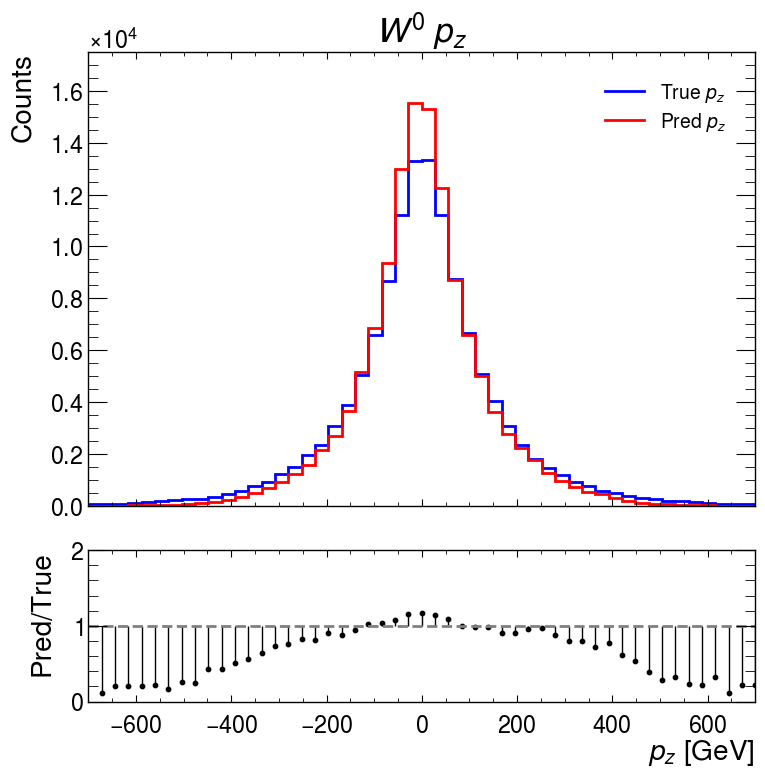

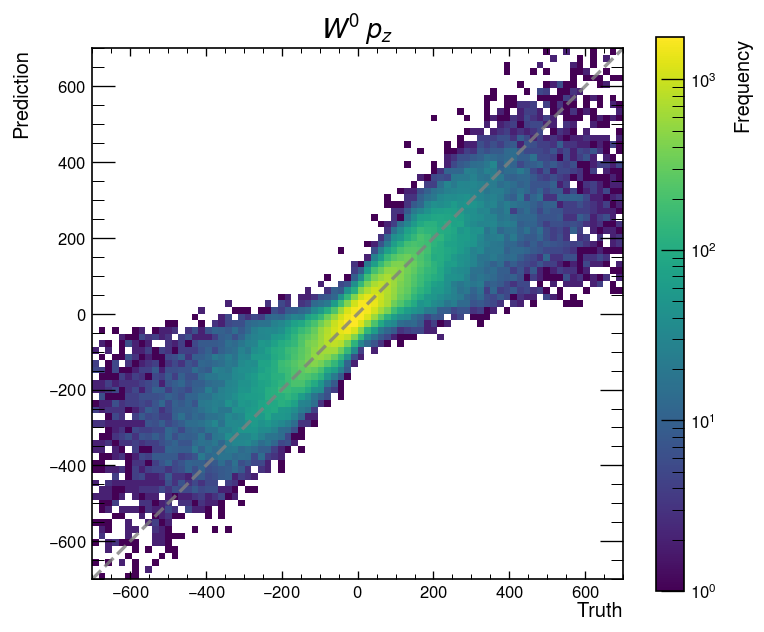

In [22]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

set_range = [-700, 700]

plot.hist(
    data=[sig_truth_inv[:, 2], sig_pred_inv[:, 2]],
    label=r"$p_{z}$",
    title="$W^{0}$ $p_{z}$",
    # # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 2],
    sig_pred_inv[:, 2],
    r"$W^{0}$ $p_{z}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2])):.3f}",
    range=set_range,
)

Truth mean: 0.111, std: 109.120, min: -1441.871, max: 1409.944


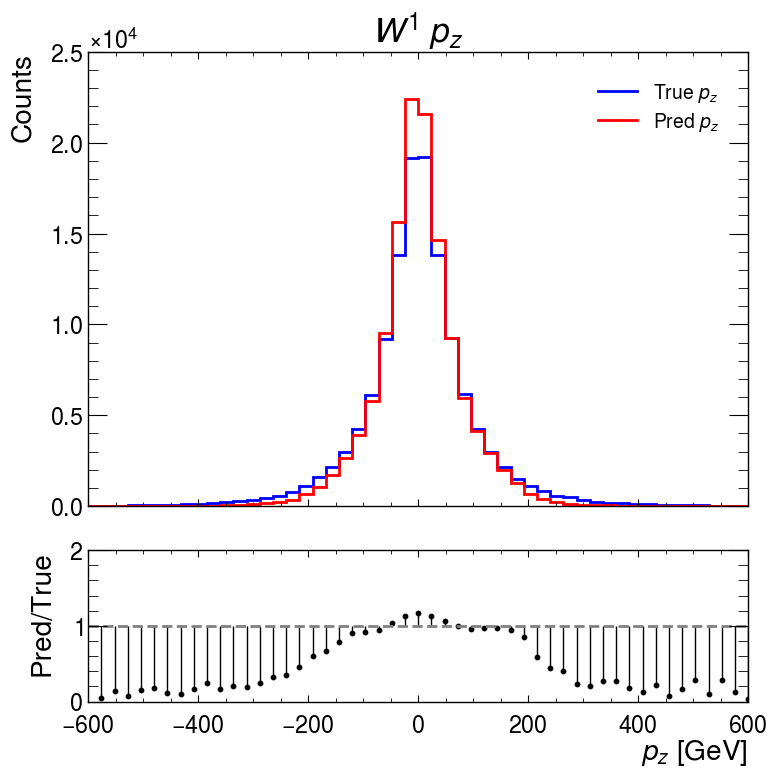

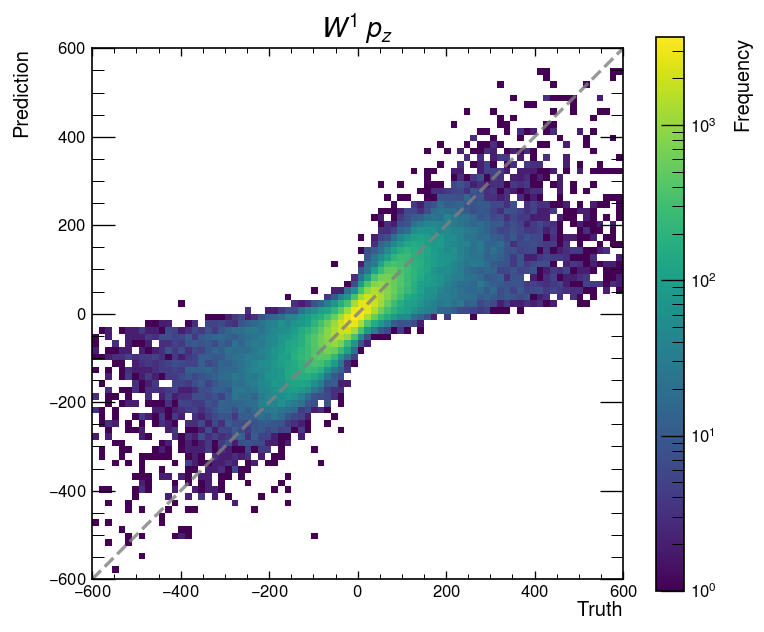

In [23]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,6]):.3f}, std: {np.std(sig_truth_inv[:,6]):.3f}, min: {np.min(sig_truth_inv[:,6]):.3f}, max: {np.max(sig_truth_inv[:,6]):.3f}"
)

set_range = [-600, 600]

plot.hist(
    data=[sig_truth_inv[:, 6], sig_pred_inv[:, 6]],
    label=r"$p_{z}$",
    title="$W^{1}$ $p_{z}$",
    # # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,6], sig_pred_inv[:,6])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 6],
    sig_pred_inv[:, 6],
    r"$W^{1}$ $p_{z}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,6], sig_pred_inv[:,6])):.3f}",
    range=set_range,
)

Truth mean: 160.059, std: 114.602, min: 26.993, max: 1795.587


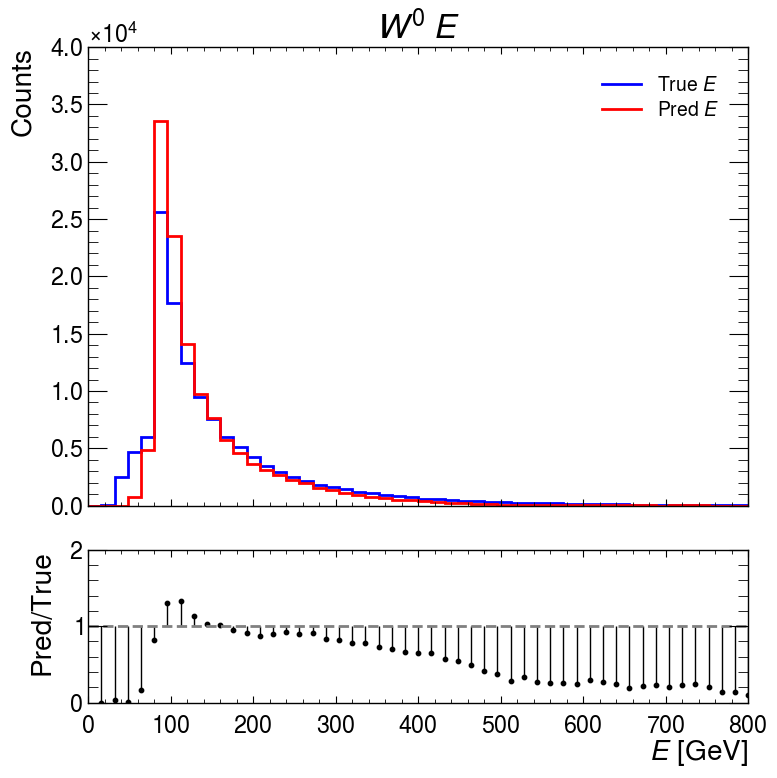

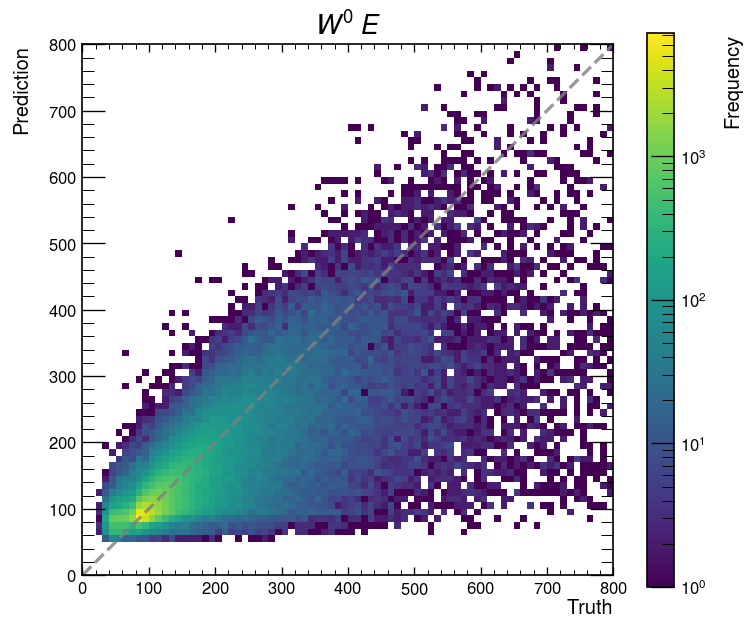

In [24]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

set_range = [0, 800]

plot.hist(
    data=[sig_truth_inv[:, 3], sig_pred_inv[:, 3]],
    label=r"$E$",
    title="$W^{0}$ $E$",
    # # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 3],
    sig_pred_inv[:, 3],
    r"$W^{0}$ $E$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3])):.3f}",
    range=set_range,
)

Truth mean: 95.622, std: 77.116, min: 13.418, max: 1445.832


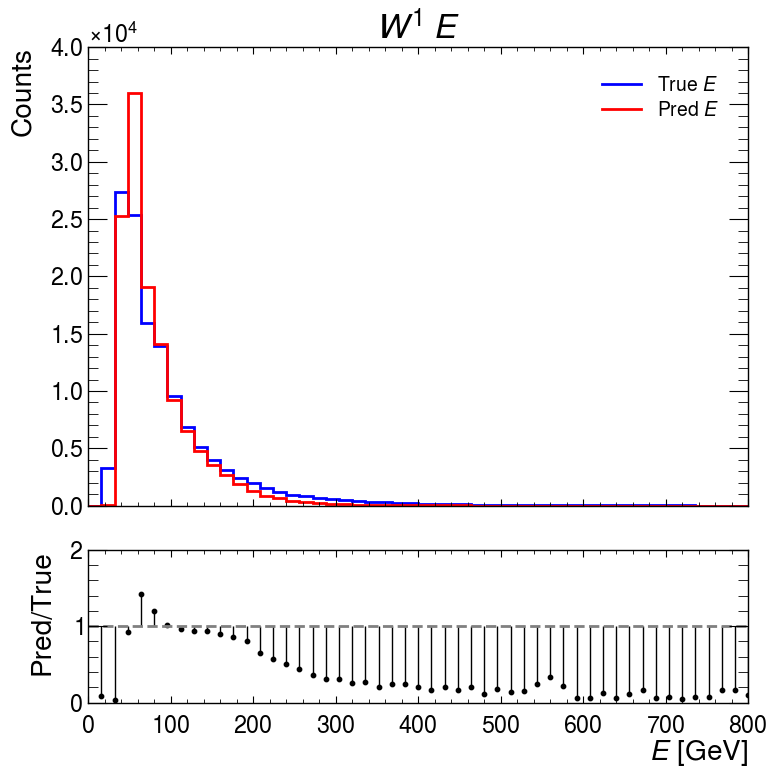

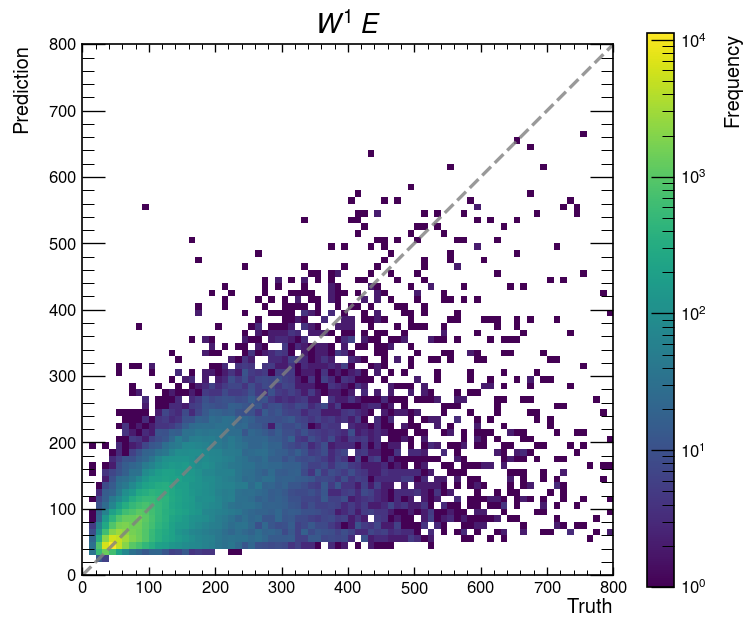

In [25]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,7]):.3f}, std: {np.std(sig_truth_inv[:,7]):.3f}, min: {np.min(sig_truth_inv[:,7]):.3f}, max: {np.max(sig_truth_inv[:,7]):.3f}"
)

set_range = [0, 800]

plot.hist(
    data=[sig_truth_inv[:, 7], sig_pred_inv[:, 7]],
    label=r"$E$",
    title="$W^{1}$ $E$",
    # # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,7], sig_pred_inv[:,7])):.3f}",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 7],
    sig_pred_inv[:, 7],
    r"$W^{1}$ $E$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,7], sig_pred_inv[:,7])):.3f}",
    range=set_range,
)

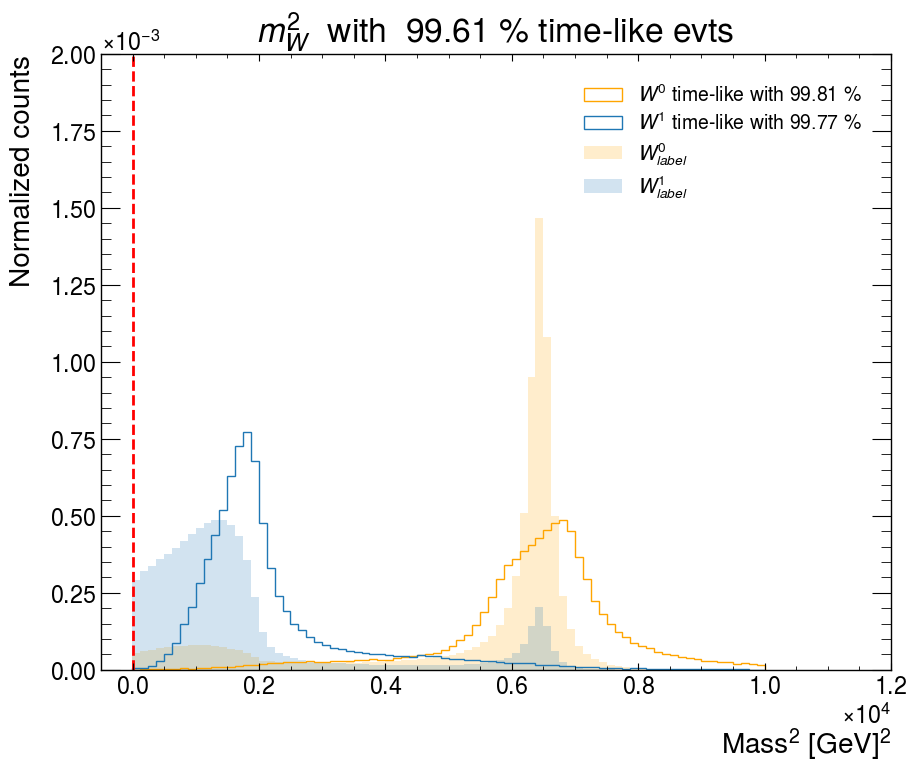

In [26]:
lead_time_like = np.square(sig_pred_inv[:, 3]) - np.sum(
    np.square(sig_pred_inv[:, 0:3]), axis=1
)
lead_time_mask = (lead_time_like > 0) * 1
sublead_time_like = np.square(sig_pred_inv[:, 7]) - np.sum(
    np.square(sig_pred_inv[:, 4:7]), axis=1
)
sublead_time_mask = (sublead_time_like > 0) * 1

bin_edges = np.linspace(-5, 1.0e4, 81)
figure = plt.figure(figsize=(10, 8))
plt.hist(
    lead_time_like,
    bins=bin_edges,
    fill=False,
    color="orange",
    histtype="step",
    label=r"$W^{0}$ "
    + f"time-like with {100 * np.sum(lead_time_mask) / len(lead_time_mask):.2f} %",
    density=True,
)
plt.hist(
    sublead_time_like,
    bins=bin_edges,
    fill=False,
    color="tab:blue",
    histtype="step",
    label=r"$W^{1}$ "
    + f"time-like with {100 * np.sum(sublead_time_mask) / len(sublead_time_mask):.2f} %",
    density=True,
)
plt.hist(
    np.square(w_lead.m),
    bins=bin_edges,
    color="orange",
    fill=True,
    histtype="bar",
    alpha=0.2,
    label=r"$W_{label}^{0}$",
    density=True,
)
plt.hist(
    np.square(w_sublead.m),
    bins=bin_edges,
    color="tab:blue",
    fill=True,
    histtype="bar",
    alpha=0.2,
    label=r"$W_{label}^{1}$",
    density=True,
)
plt.vlines(0, 0, 2e-3, color="red", linestyle="--")
plt.xlim(-5e2, 1.2e4)
plt.ylim(0, 2e-3)
plt.xlabel(r"Mass$^{2}$ [GeV]$^{2}$", labelpad=20)
plt.ylabel("Normalized counts")
plt.title(
    r"$m^{2}_{W}$ "
    + f" with {100 * np.sum(lead_time_mask * sublead_time_mask) / len(lead_time_mask): .2f} % time-like evts"
)
plt.legend(loc="upper right")
plt.show()

Truth mean: 3611.860, std: 2614.367, min: 3.710, max: 11497.875


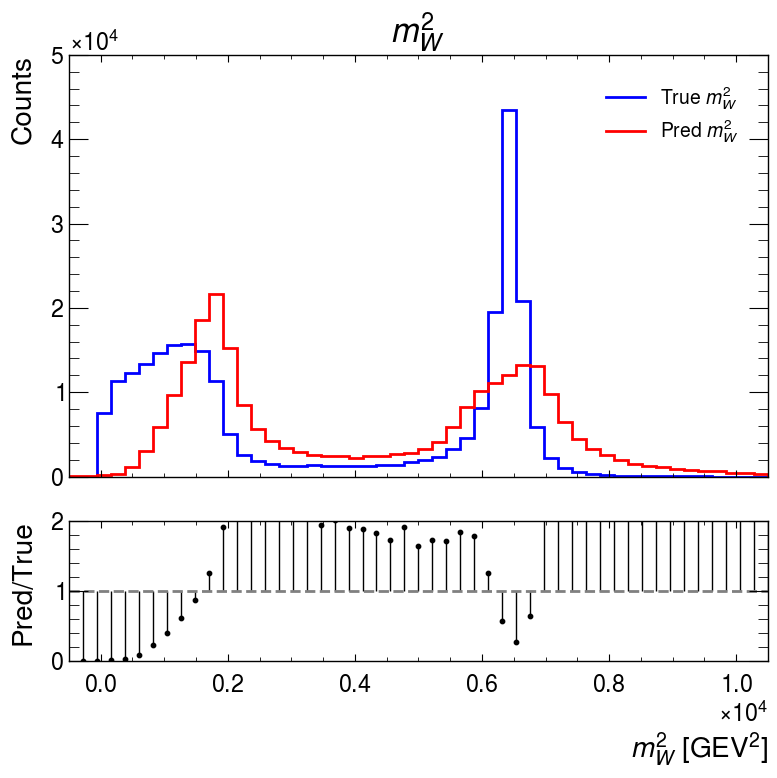

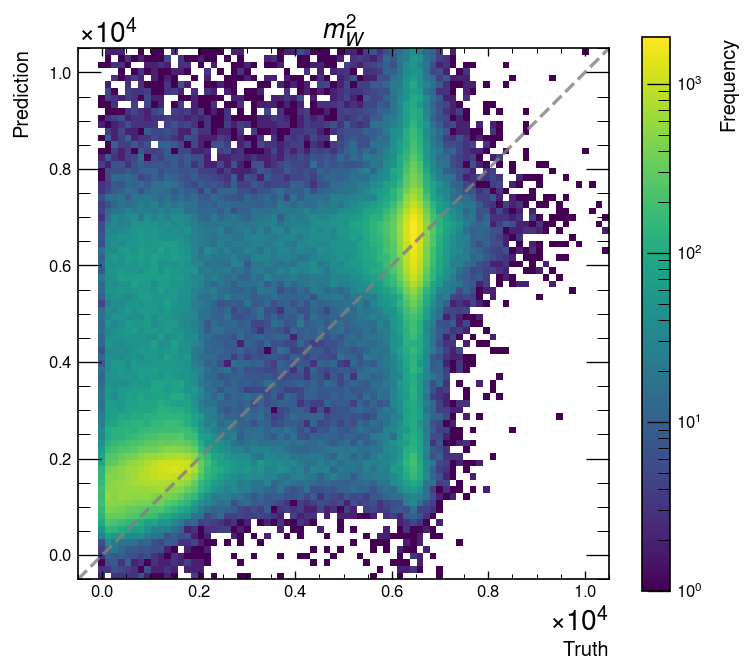

In [27]:
# TODO: 2d mass squared
pred_m2 = np.concatenate([lead_time_like, sublead_time_like], axis=-1)
truth_m2 = np.concatenate(
    [np.square(w_lead.m)[test_indices], np.square(w_sublead.m)[test_indices]], axis=-1
)

print(
    f"Truth mean: {np.mean(truth_m2):.3f}, std: {np.std(truth_m2):.3f}, min: {np.min(truth_m2):.3f}, max: {np.max(truth_m2):.3f}"
)

set_range = [-500, 10_500]

plot.hist(
    data=[truth_m2, pred_m2],
    label=r"$m_{W}^{2}$",
    title="$m_{W}^{2}$",
    # # + f" with RMSE: {np.sqrt(mean_squared_error(truth_m2, pred_m2)):.3f}",
    range=set_range,
    unit=r"[GEV$^{2}$]",
    xpad=24,
)

plot.plot_2d_histogram(
    truth_m2,
    pred_m2,
    r"$m_{W}^{2}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(truth_m2, pred_m2)):.3f}",
    range=set_range,
    xpad=24,
)

In [28]:
# validate by truth data

truth_lead_lep = Truth_lead_lep()
truth_sublead_lep = Truth_sublead_lep()
truth_met = Truth_met()

In [29]:
truth_obs_var = np.column_stack(
    (
        truth_lead_lep.px,
        truth_lead_lep.py,
        # truth_lead_lep.pz,
        np.log(truth_lead_lep.energy),
        # truth_lead_lep.pt,
        truth_lead_lep.eta,
        # truth_lead_lep.phi,
        truth_sublead_lep.px,
        truth_sublead_lep.py,
        # truth_sublead_lep.pz,
        np.log(truth_sublead_lep.energy),
        # truth_sublead_lep.pt,
        truth_sublead_lep.eta,
        # truth_sublead_lep.phi,
        truth_met.px,
        truth_met.py,
        # truth_met.pt,
        # truth_met.phi,
        # Truth_dilep.px,
        # Truth_dilep.py,
        # Truth_dilep.pz,
        # Truth_dilep.energy,
        # Truth_dilep.pt,
        # Truth_dilep.eta,
        # Truth_dilep.phi,
        # Truth_dilep.m,
    ),
)[PRE_CUT][test_indices]

# truth labels
w_lead_truth_p4 = pd.DataFrame(w_lead.p4[PRE_CUT][test_indices])
w_sublead_truth_p4 = pd.DataFrame(w_sublead.p4[PRE_CUT][test_indices])
print(w_lead_truth_p4.shape)
print(w_sublead_truth_p4.shape)
TRUTH_ROBUST_OBS = StandardScaler()
truth_obs_var = TRUTH_ROBUST_OBS.fit_transform(truth_obs_var)
print(truth_obs_var.shape)

(127740, 4)
(127740, 4)
(127740, 10)


In [30]:
truth_pred_int = model.predict(truth_obs_var)
# truth_pred_int = np.concatenate([truth_pred_int[0], truth_pred_int[1]], axis=-1)

truth_pred_w_lead_px = truth_pred_int[:, 0]
truth_pred_w_lead_py = truth_pred_int[:, 1]
truth_pred_w_lead_pz = truth_pred_int[:, 2]
truth_pred_w_lead_energy = truth_pred_int[:, 3]
truth_pred_w_lead_p4 = np.vstack(
    [
        truth_pred_w_lead_px,
        truth_pred_w_lead_py,
        truth_pred_w_lead_pz,
        truth_pred_w_lead_energy,
    ]
).T
truth_pred_w_sublead_px = truth_pred_int[:, 4]
truth_pred_w_sublead_py = truth_pred_int[:, 5]
truth_pred_w_sublead_pz = truth_pred_int[:, 6]
truth_pred_w_sublead_energy = truth_pred_int[:, 7]
truth_pred_w_sublead_p4 = np.vstack(
    [
        truth_pred_w_sublead_px,
        truth_pred_w_sublead_py,
        truth_pred_w_sublead_pz,
        truth_pred_w_sublead_energy,
    ]
).T

  30/3992 [..............................] - ETA: 7s 

3992/3992 [==============================] - 10s 2ms/step


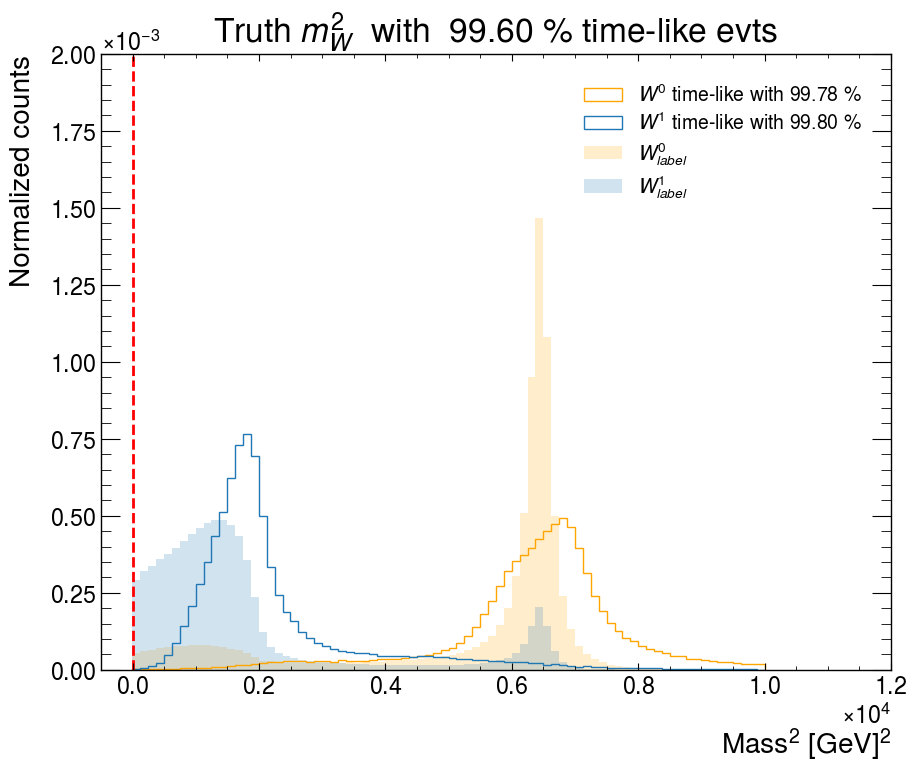

In [31]:
truth_lead_time_like = np.square(truth_pred_w_lead_p4[:, 3]) - np.sum(
    np.square(truth_pred_w_lead_p4[:, 0:-1]), axis=1
)
truth_lead_time_mask = (truth_lead_time_like >= 0) * 1
truth_sublead_time_like = np.square(truth_pred_w_sublead_p4[:, 3]) - np.sum(
    np.square(truth_pred_w_sublead_p4[:, 0:-1]), axis=1
)
truth_sublead_time_mask = (truth_sublead_time_like >= 0) * 1

bin_edges = np.linspace(-5, 1.0e4, 81)
figure = plt.figure(figsize=(10, 8))
plt.hist(
    truth_lead_time_like,
    bins=bin_edges,
    fill=False,
    color="orange",
    histtype="step",
    label=r"$W^{0}$ "
    + f"time-like with {100 * np.sum(truth_lead_time_mask) / len(truth_lead_time_mask):.2f} %",
    density=True,
)
plt.hist(
    truth_sublead_time_like,
    bins=bin_edges,
    fill=False,
    color="tab:blue",
    histtype="step",
    label=r"$W^{1}$ "
    + f"time-like with {100 * np.sum(truth_sublead_time_mask) / len(truth_sublead_time_mask):.2f} %",
    density=True,
)
plt.hist(
    np.square(w_lead.m),
    bins=bin_edges,
    color="orange",
    fill=True,
    histtype="bar",
    alpha=0.2,
    label=r"$W_{label}^{0}$",
    density=True,
)
plt.hist(
    np.square(w_sublead.m),
    bins=bin_edges,
    color="tab:blue",
    fill=True,
    histtype="bar",
    alpha=0.2,
    label=r"$W_{label}^{1}$",
    density=True,
)
plt.vlines(0, 0, 2e-3, color="red", linestyle="--")
plt.xlim(-5e2, 1.2e4)
plt.ylim(0, 2e-3)
plt.xlabel(r"Mass$^{2}$ [GeV]$^{2}$", labelpad=20)
plt.ylabel("Normalized counts")
plt.title(
    r"Truth $m^{2}_{W}$ "
    + f" with {100 * np.sum(truth_lead_time_mask * truth_sublead_time_mask) / len(truth_lead_time_mask): .2f} % time-like evts"
)
plt.legend(loc="upper right")
plt.show()

Truth mean: 0.118, std: 38.116, min: -509.129, max: 642.655


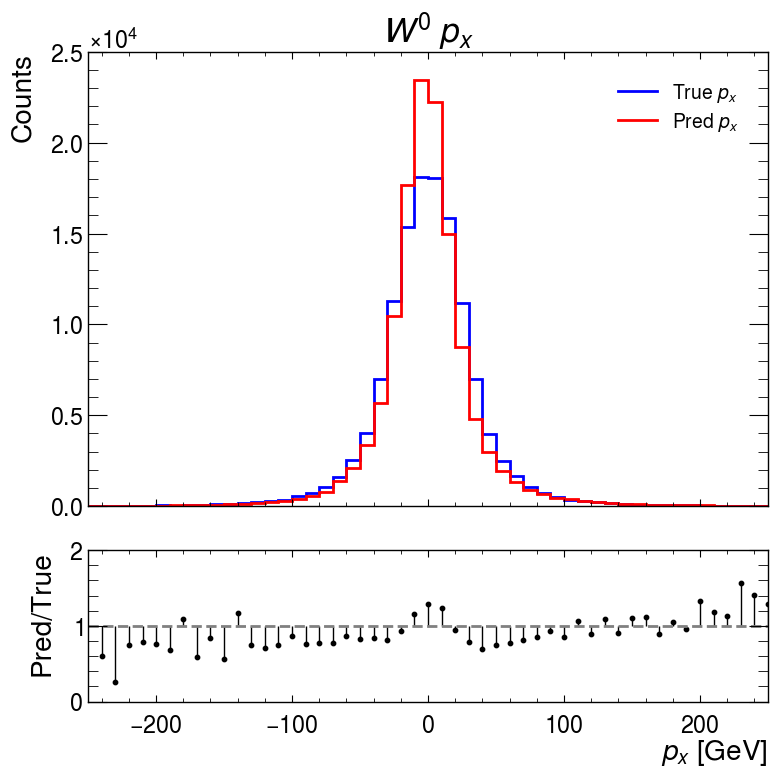

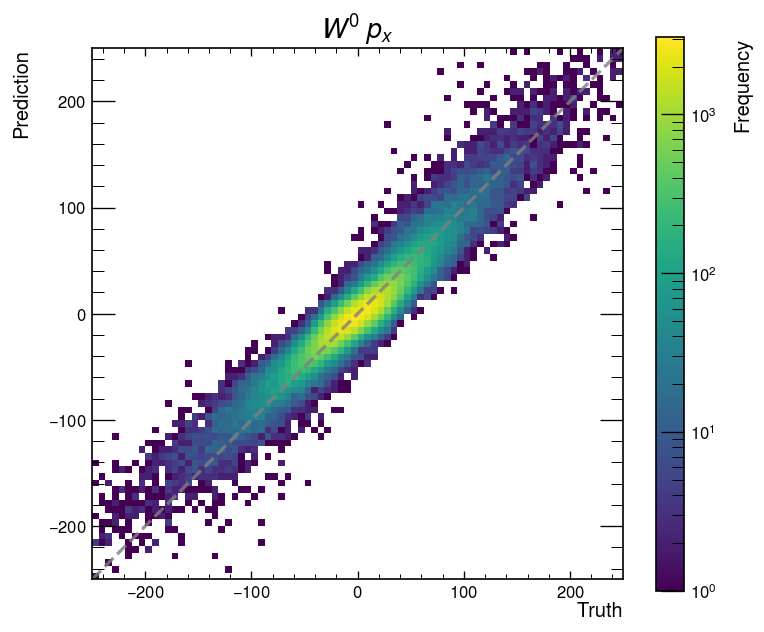

In [32]:
print(
    f"Truth mean: {np.mean(w_lead_truth_p4[0]):.3f}, std: {np.std(w_lead_truth_p4[0]):.3f}, min: {np.min(w_lead_truth_p4[0]):.3f}, max: {np.max(w_lead_truth_p4[0]):.3f}"
)

set_range = [-250, 250]

plot.hist(
    data=[w_lead_truth_p4[0], truth_pred_w_lead_p4[:, 0]],
    label=r"$p_{x}$",
    title="$W^{0}$ $p_{x}$",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    w_lead_truth_p4[0],
    truth_pred_w_lead_p4[:, 0],
    r"$W^{0}$ $p_{x}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(w_lead_truth_p4[0], truth_pred_w_lead_p4[:, 0])):.3f}",
    range=set_range,
)

Truth mean: 0.043, std: 38.211, min: -552.205, max: 490.982


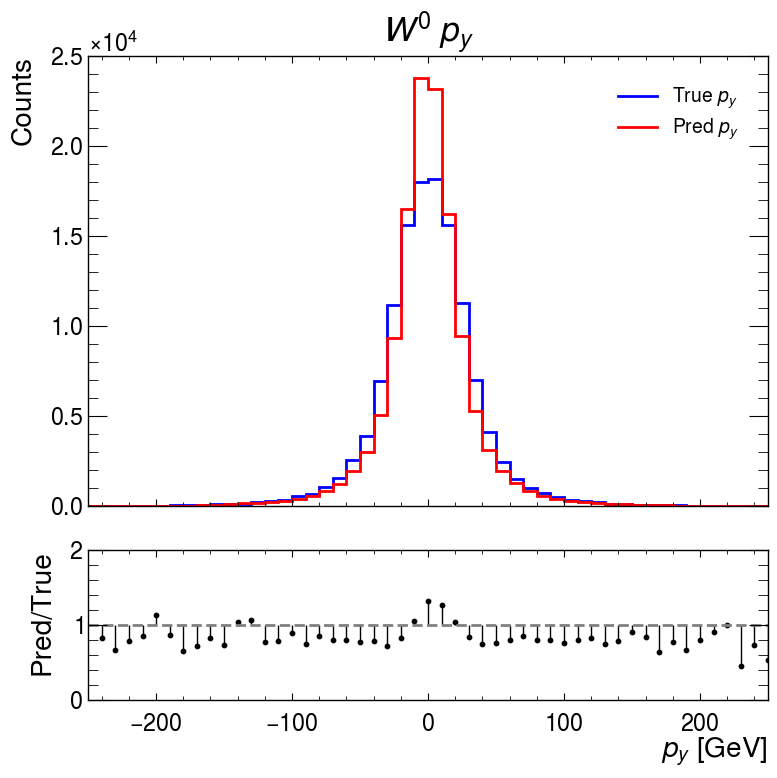

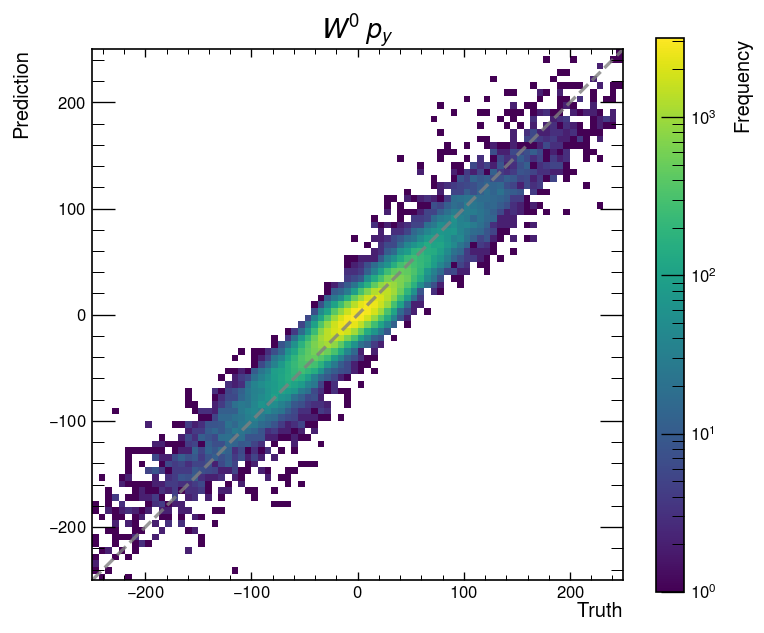

In [33]:
print(
    f"Truth mean: {np.mean(w_lead_truth_p4[1]):.3f}, std: {np.std(w_lead_truth_p4[1]):.3f}, min: {np.min(w_lead_truth_p4[1]):.3f}, max: {np.max(w_lead_truth_p4[1]):.3f}"
)

set_range = [-250, 250]

plot.hist(
    data=[w_lead_truth_p4[1], truth_pred_w_lead_p4[:, 1]],
    label=r"$p_{y}$",
    title="$W^{0}$ $p_{y}$",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    w_lead_truth_p4[1],
    truth_pred_w_lead_p4[:, 1],
    r"$W^{0}$ $p_{y}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(w_lead_truth_p4[1], truth_pred_w_lead_p4[:, 1])):.3f}",
    range=set_range,
)

Truth mean: 0.370, std: 174.439, min: -1558.070, max: 1793.634


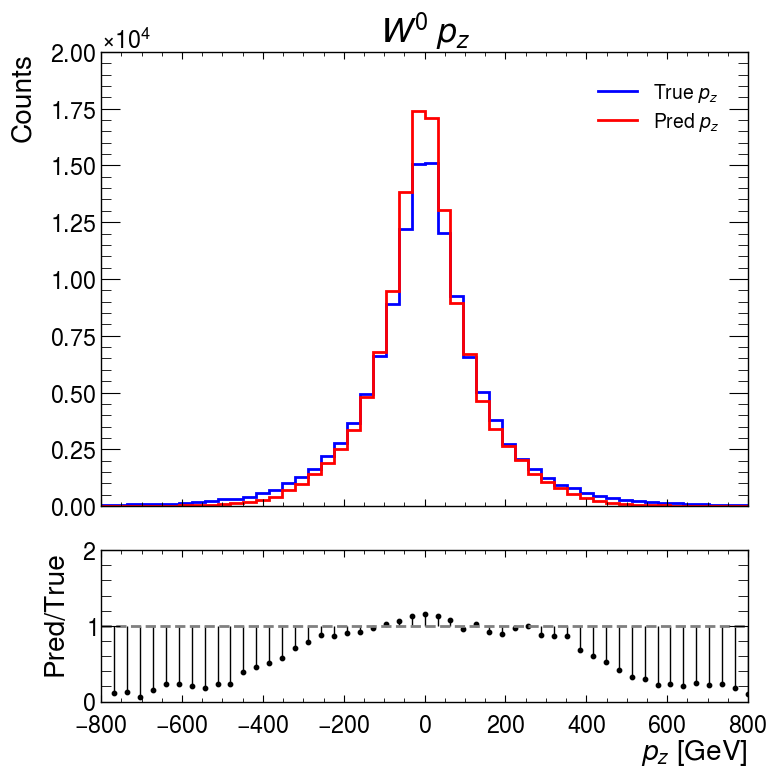

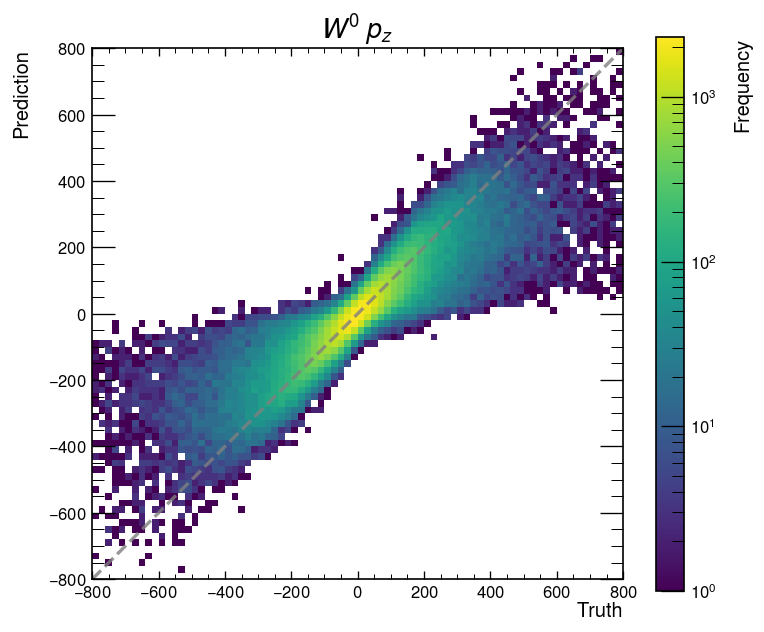

In [34]:
print(
    f"Truth mean: {np.mean(w_lead_truth_p4[2]):.3f}, std: {np.std(w_lead_truth_p4[2]):.3f}, min: {np.min(w_lead_truth_p4[2]):.3f}, max: {np.max(w_lead_truth_p4[2]):.3f}"
)

set_range = [-800, 800]

plot.hist(
    data=[w_lead_truth_p4[2], truth_pred_w_lead_p4[:, 2]],
    label=r"$p_{z}$",
    title="$W^{0}$ $p_{z}$",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    w_lead_truth_p4[2],
    truth_pred_w_lead_p4[:, 2],
    r"$W^{0}$ $p_{z}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(w_lead_truth_p4[2], truth_pred_w_lead_p4[:, 2])):.3f}",
    range=set_range,
)

Truth mean: 160.059, std: 114.602, min: 26.993, max: 1795.587


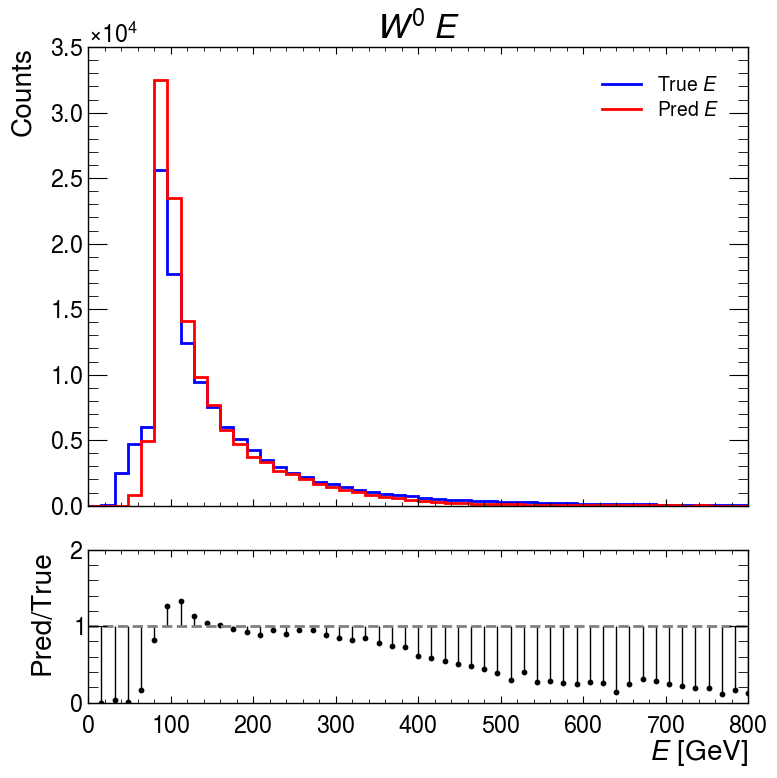

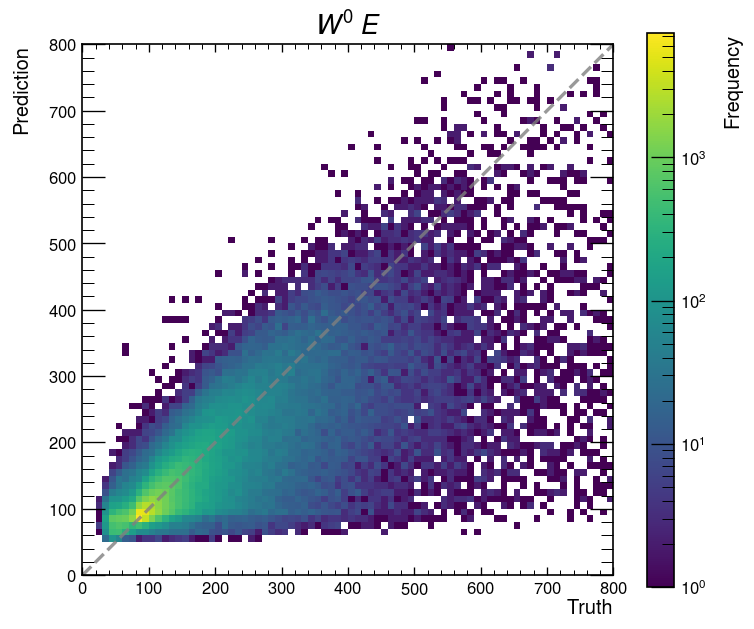

In [35]:
print(
    f"Truth mean: {np.mean(w_lead_truth_p4[3]):.3f}, std: {np.std(w_lead_truth_p4[3]):.3f}, min: {np.min(w_lead_truth_p4[3]):.3f}, max: {np.max(w_lead_truth_p4[3]):.3f}"
)

set_range = [0, 800]

plot.hist(
    data=[w_lead_truth_p4[3], truth_pred_w_lead_p4[:, 3]],
    label=r"$E$",
    title="$W^{0}$ $E$",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    w_lead_truth_p4[3],
    truth_pred_w_lead_p4[:, 3],
    r"$W^{0}$ $E$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(w_lead_truth_p4[3], truth_pred_w_lead_p4[:, 3])):.3f}",
    range=set_range,
)

Truth mean: 0.058, std: 26.084, min: -450.792, max: 414.779


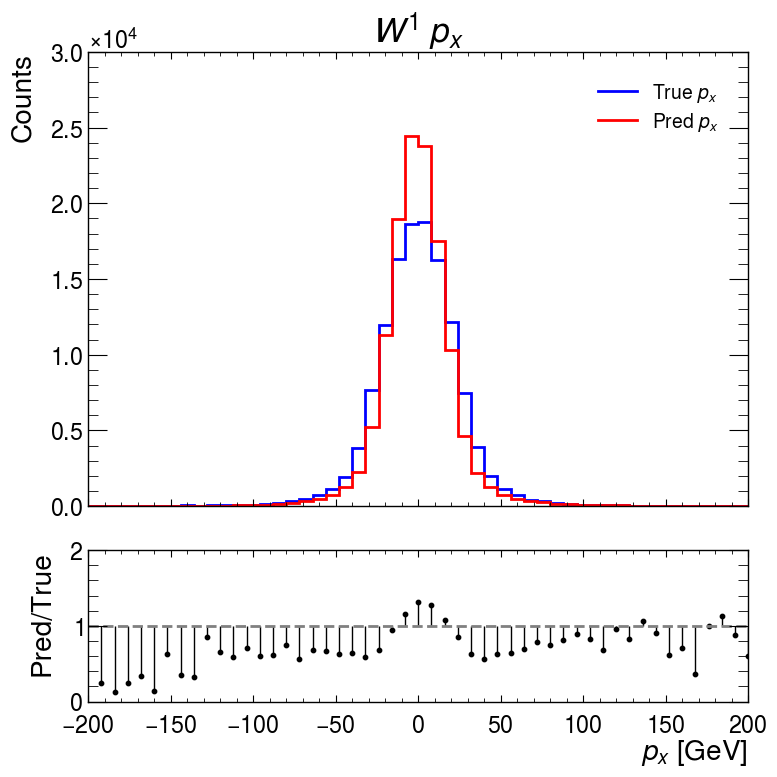

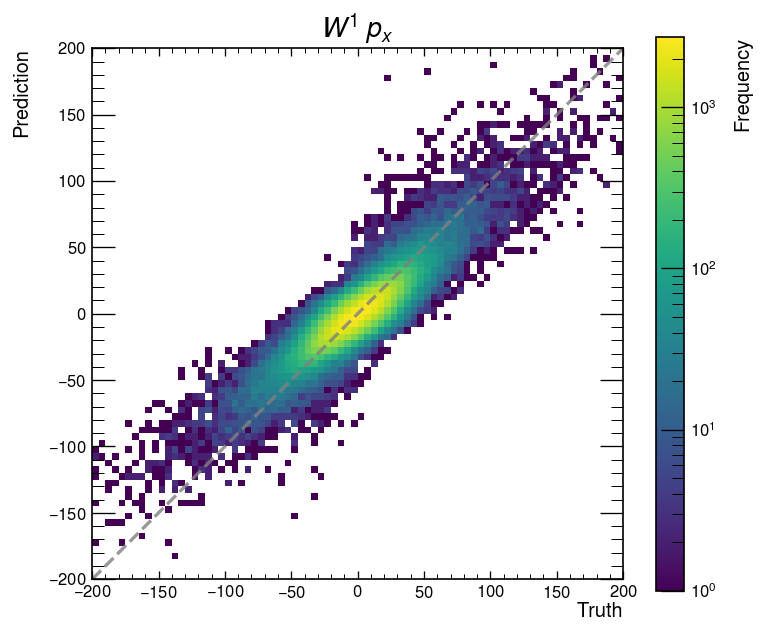

In [36]:
print(
    f"Truth mean: {np.mean(w_sublead_truth_p4[0]):.3f}, std: {np.std(w_sublead_truth_p4[0]):.3f}, min: {np.min(w_sublead_truth_p4[0]):.3f}, max: {np.max(w_sublead_truth_p4[0]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[w_sublead_truth_p4[0], truth_pred_w_sublead_p4[:, 0]],
    label=r"$p_{x}$",
    title="$W^{1}\ p_{x}$",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    w_sublead_truth_p4[0],
    truth_pred_w_sublead_p4[:, 0],
    r"$W^{1}\ p_{x}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(w_sublead_truth_p4[0], truth_pred_w_sublead_p4[:, 0])):.3f}",
    range=set_range,
)

Truth mean: -0.006, std: 26.259, min: -420.723, max: 544.802


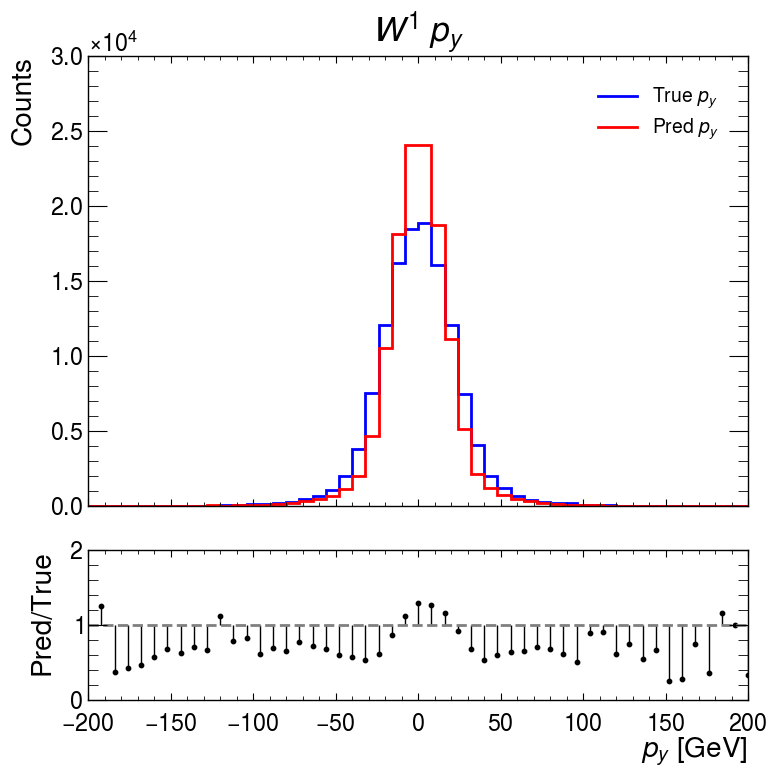

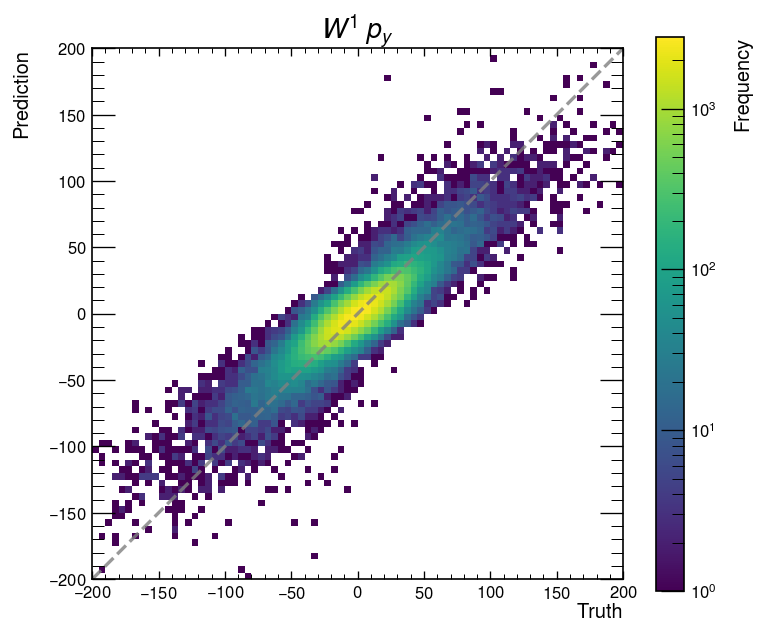

In [37]:
print(
    f"Truth mean: {np.mean(w_sublead_truth_p4[1]):.3f}, std: {np.std(w_sublead_truth_p4[1]):.3f}, min: {np.min(w_sublead_truth_p4[1]):.3f}, max: {np.max(w_sublead_truth_p4[1]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[w_sublead_truth_p4[1], truth_pred_w_sublead_p4[:, 1]],
    label=r"$p_{y}$",
    title="$W^{1}\ p_{y}$",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    w_sublead_truth_p4[1],
    truth_pred_w_sublead_p4[:, 1],
    r"$W^{1}\ p_{y}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(w_sublead_truth_p4[1], truth_pred_w_sublead_p4[:, 1])):.3f}",
    range=set_range,
)

Truth mean: 0.111, std: 109.120, min: -1441.871, max: 1409.944


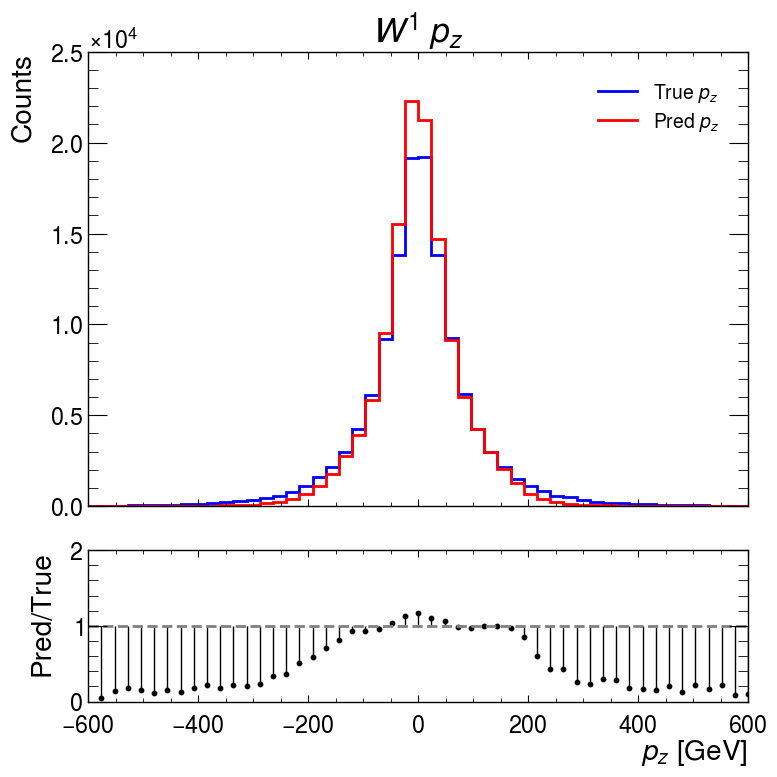

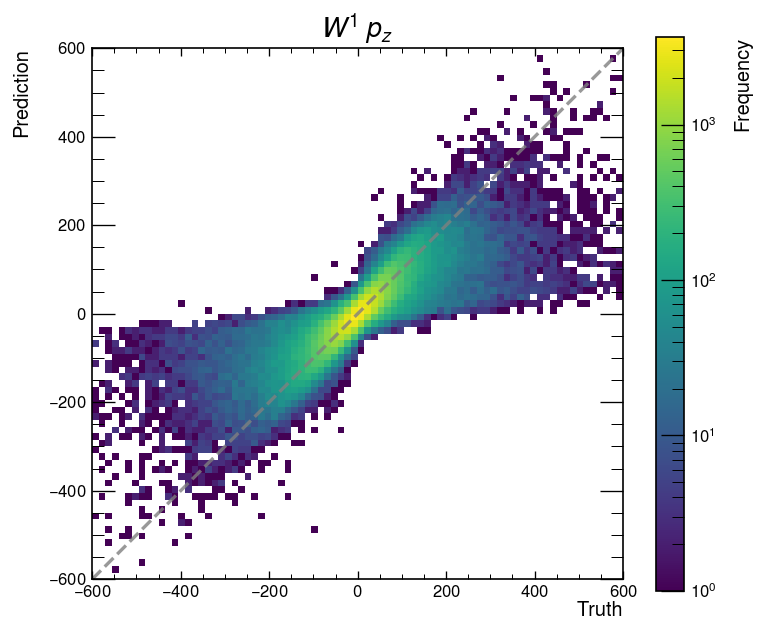

In [38]:
print(
    f"Truth mean: {np.mean(w_sublead_truth_p4[2]):.3f}, std: {np.std(w_sublead_truth_p4[2]):.3f}, min: {np.min(w_sublead_truth_p4[2]):.3f}, max: {np.max(w_sublead_truth_p4[2]):.3f}"
)

set_range = [-600, 600]

plot.hist(
    data=[w_sublead_truth_p4[2], truth_pred_w_sublead_p4[:, 2]],
    label=r"$p_{z}$",
    title="$W^{1}$ $p_{z}$",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    w_sublead_truth_p4[2],
    truth_pred_w_sublead_p4[:, 2],
    r"$W^{1}$ $p_{z}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(w_sublead_truth_p4[2], truth_pred_w_sublead_p4[:, 2])):.3f}",
    range=set_range,
)

Truth mean: 95.622, std: 77.116, min: 13.418, max: 1445.832


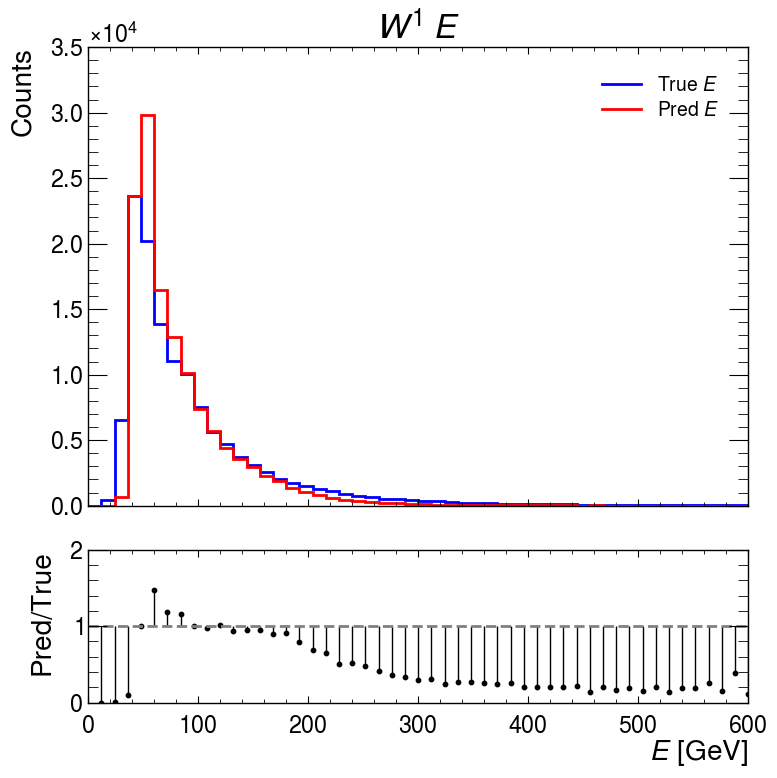

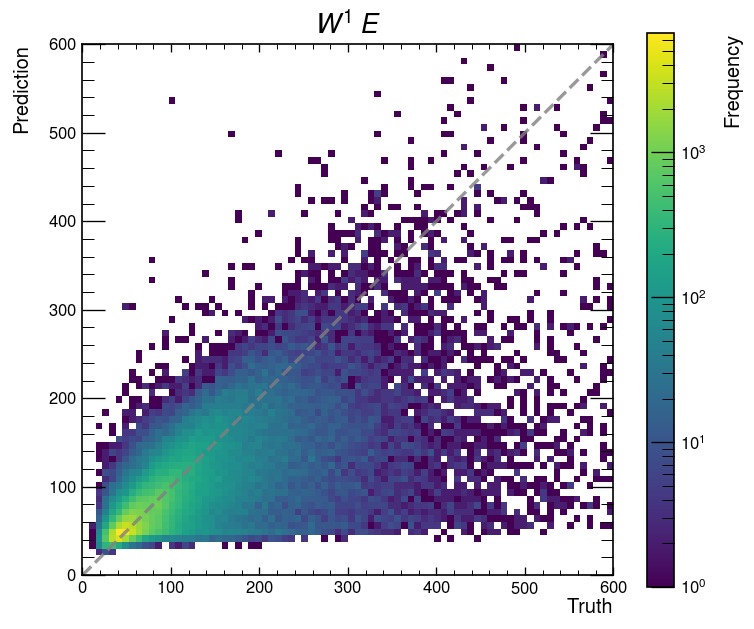

In [39]:
print(
    f"Truth mean: {np.mean(w_sublead_truth_p4[3]):.3f}, std: {np.std(w_sublead_truth_p4[3]):.3f}, min: {np.min(w_sublead_truth_p4[3]):.3f}, max: {np.max(w_sublead_truth_p4[3]):.3f}"
)

set_range = [0, 600]

plot.hist(
    data=[w_sublead_truth_p4[3], truth_pred_w_sublead_p4[:, 3]],
    label=r"$E$",
    title="$W^{1}$ $E$",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    w_sublead_truth_p4[3],
    truth_pred_w_sublead_p4[:, 3],
    r"$W^{1}$ $E$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(w_sublead_truth_p4[3], truth_pred_w_sublead_p4[:, 3])):.3f}",
    range=set_range,
)

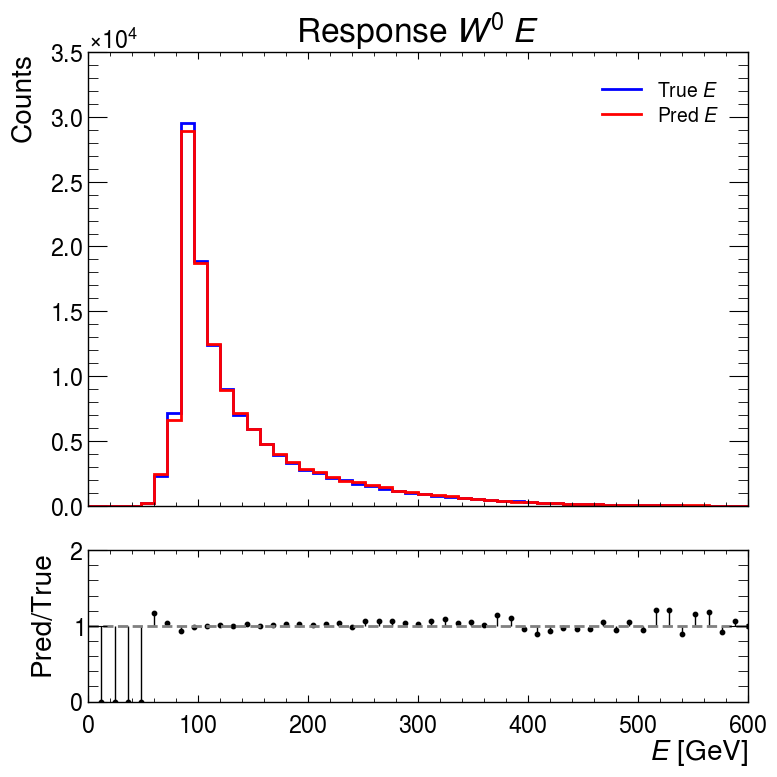

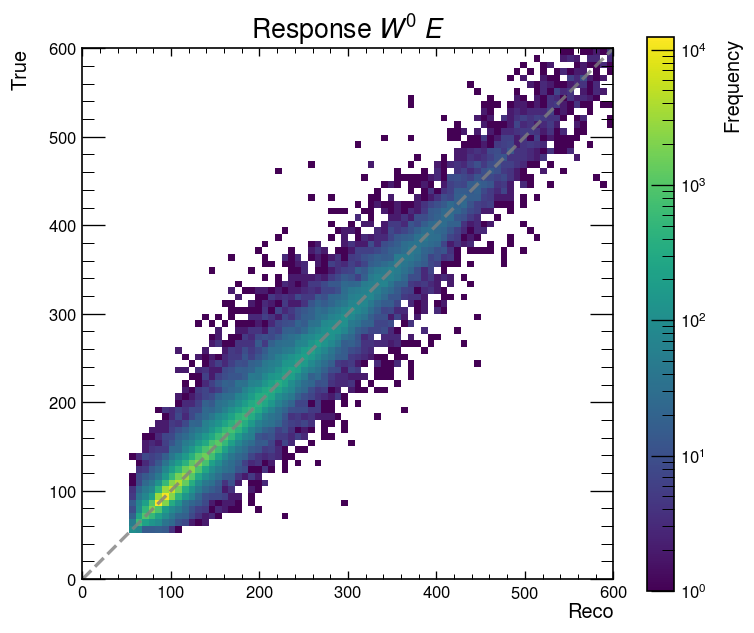

In [40]:
set_range = [0, 600]

plot.hist(
    data=[sig_pred_inv[:, 3], truth_pred_w_lead_p4[:, 3]],
    label=r"$E$",
    title="Response $W^{0}\ E$",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_pred_inv[:, 3],
    truth_pred_w_lead_p4[:, 3],
    r"Response $W^{0}\ E$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_pred_inv[:, 3], truth_pred_w_lead_p4[:, 3])):.3f}",
    range=set_range,
    xlabel=r"Reco",
    ylabel=r"True",
)

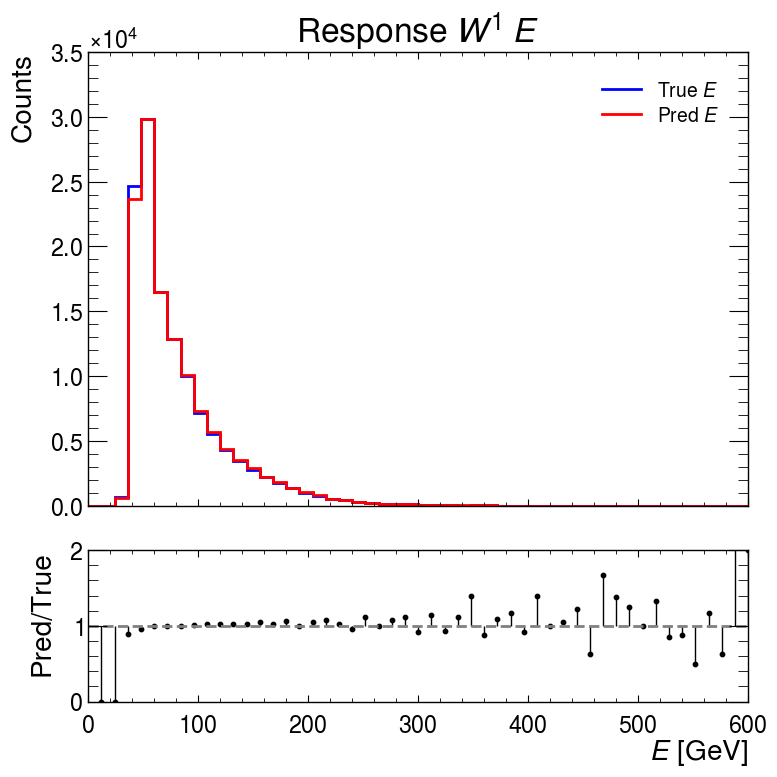

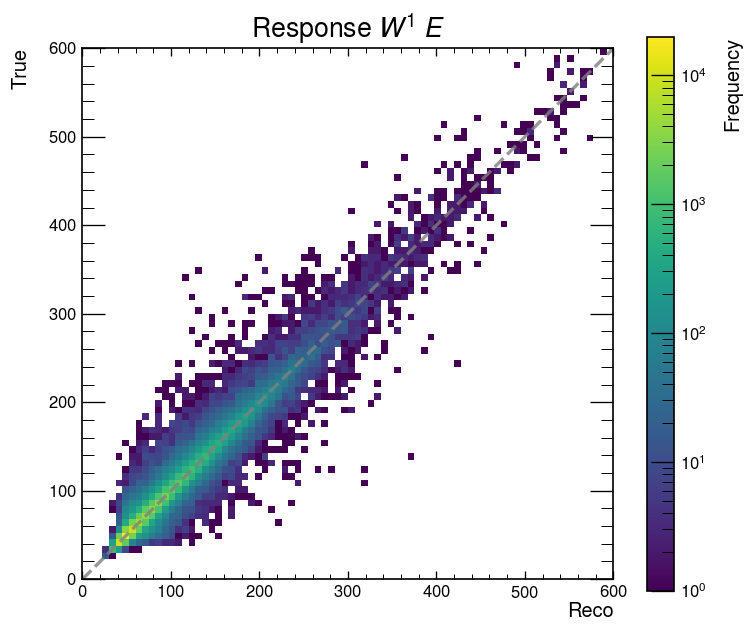

In [41]:
set_range = [0, 600]

plot.hist(
    data=[sig_pred_inv[:, 7], truth_pred_w_sublead_p4[:, 3]],
    label=r"$E$",
    title="Response $W^{1}\ E$",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_pred_inv[:, 7],
    truth_pred_w_sublead_p4[:, 3],
    r"Response $W^{1}\ E$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_pred_inv[:, 7], truth_pred_w_lead_p4[:, 3])):.3f}",
    range=set_range,
    xlabel=r"Reco",
    ylabel=r"True",
)

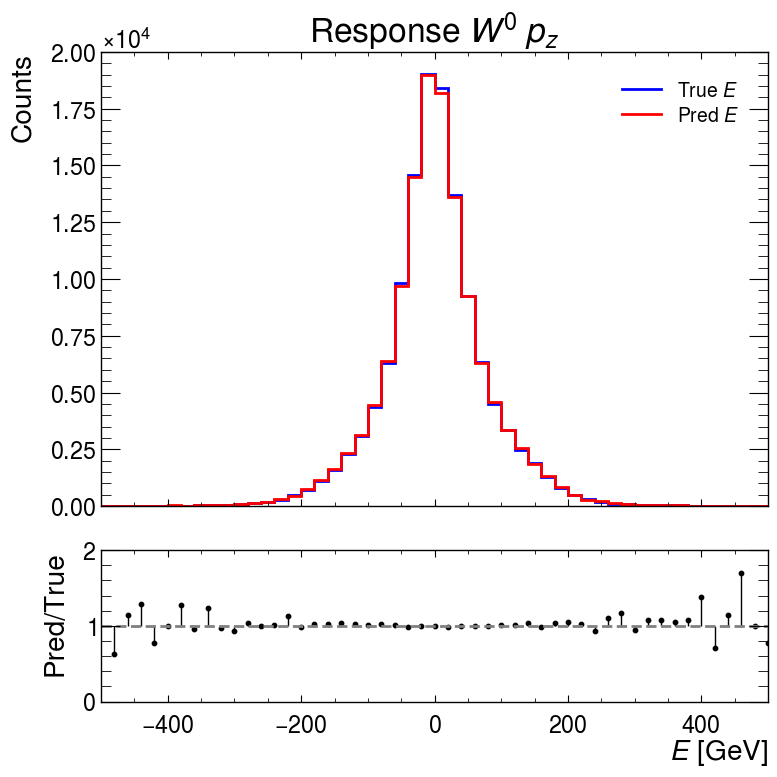

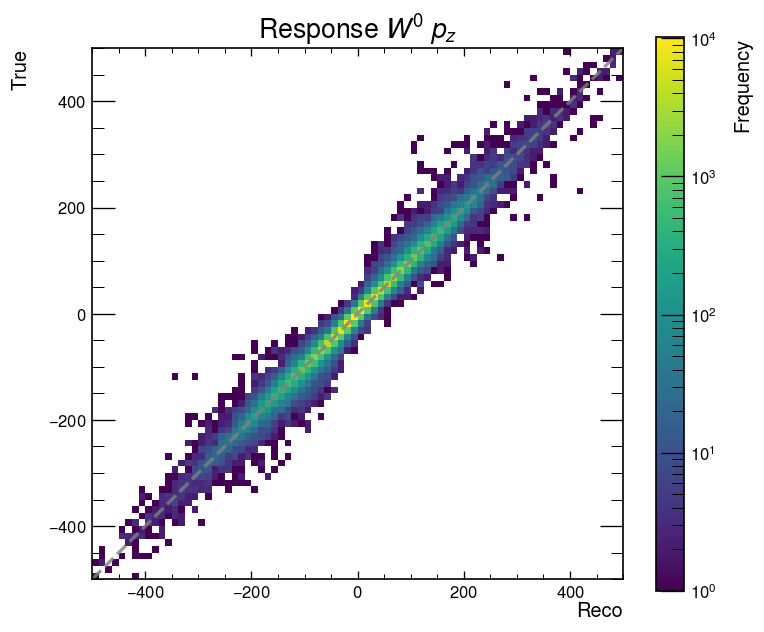

In [42]:
set_range = [-500, 500]

plot.hist(
    data=[sig_pred_inv[:, 6], truth_pred_w_sublead_p4[:, 2]],
    label=r"$E$",
    title="Response $W^{0}\ p_{z}$",
    range=set_range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_pred_inv[:, 6],
    truth_pred_w_sublead_p4[:, 2],
    r"Response $W^{0}\ p_{z}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_pred_inv[:, 6], truth_pred_w_lead_p4[:, 2])):.3f}",
    range=set_range,
    xlabel=r"Reco",
    ylabel=r"True",
)